# Biweekly Active Users Analysis

Sept 4, 2018 by Summer  
Last updated: Sept 8

**to do:**  

- double check gender gen, join key, what's the percentage of cheat in gender?
- propotion of time period. Same pattern, coorelation with other things? (time period) close to gender?age?...
- income based on zip code. Compare with income in dif zipcode. Will it affect retention? college times have high retention? Will have impact on marketing
- create trello. popose something I want to talk about.

**doing:**  

- 
- 

**done:**    

- 
- 

---
## Some Explanations

- We define **active users** as they engage in video for at least two every two weeks(biweeks).

- The duration of first **biweek** is between day1 and day14 after register.

- **count_video** is how many unique videos they engage in after register.

- **max_viewduration**(we'll update to max_elapse later) is the duration of most recent engage activity after user registered. If it is 100, it means user's most recent activity happened after 100 days from registeration, which indicate this user has high stickness to our platform.

- **min_viewduration**(we'll update to min_elapse later) is the duration of earliest engage activity after user registered. If it is 0, it means they engage in videos right after register.

- Two columns contain **gender**, one from fact_users, and the other from facebook. We will use facebook gender as reference if it has value. 

- All data are extracted from superset, from **April 15 2018** to **30 days before today**.


## Workflow

1. Wrangle, prepare, and cleanse the data. 
 - overvoew
 - null value 
 - extreme value)
2. Analyze, identify patterns, and explore the data. 
 - numerical
 - categorical
 - add gender from facebook info, compare with original gender
 - extract percentage from view_time, find max view_time and its corresponding time, correlation with other features
 - create y(retention)
 - add income level effect
 - heatmap y xs
3. Model, predict and solve the problem.
4. Visualize, report, and present the problem solving steps and final conclusion.


In [294]:
import numpy as np
import pandas as pd
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

import random as rnd
# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

## Wrangle, prepare, and cleanse the data.

In [295]:
#df = pd.read_csv('/Users/yuwei/Desktop/LoopApps/python code/User Performance/user_retention/user_retention.csv')
df = pd.read_csv('/Users/yuwei/Desktop/biweek_retention_0904.csv')
#df = df.replace(r'\s+', np.nan, regex=True)
df.shape,df.columns


((224217, 30), Index(['user_id', 'register', 'count_video', 'max_viewduration',
        'min_viewduration', 'avg_viewduration', 'early_morning', 'morning',
        'afternoon', 'evening', 'night', 'late_night', 'biweek1', 'biweek2',
        'biweek3', 'biweek4', 'biweek5_nafter', 'user_type',
        'inserted_date_pst', 'age', 'age_group', 'birthdate', 'gender', 'lat',
        'long', 'country', 'region', 'locality', 'postal_code', 'info'],
       dtype='object'))

In [296]:
#df[df['user_type']=='guest']
#guest has no age, gender
#sum(df['user_type'] == 'guest')/len(df)
# later on, we'll delete user without age, this is to check user_type 

### Overview the data

- From the table originally created from superset, data size is 224217, with 30 features.
- Lots of NaN and UNKNOWN values.

In [297]:
df.info()
#df
#Questions here (1) ????? later discovered unknown values in age_group and gender

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224217 entries, 0 to 224216
Data columns (total 30 columns):
user_id              224217 non-null int64
register             224217 non-null object
count_video          224217 non-null int64
max_viewduration     224217 non-null int64
min_viewduration     224217 non-null int64
avg_viewduration     224217 non-null int64
early_morning        224217 non-null int64
morning              224217 non-null int64
afternoon            224217 non-null int64
evening              224217 non-null int64
night                224217 non-null int64
late_night           224217 non-null int64
biweek1              224217 non-null int64
biweek2              224217 non-null int64
biweek3              224217 non-null int64
biweek4              224217 non-null int64
biweek5_nafter       224217 non-null int64
user_type            219717 non-null object
inserted_date_pst    219717 non-null object
age                  107713 non-null float64
age_group            219

- Why **user_type** (from fact_users) has null values?  
   Did some sample check, user_id = 398759, 400319, 400400, 401436, 399131. If we search their engage_video in feed_events table, all of them only have 1 record. But if we include show_video, some of them have more than 1 record. For those users, we cannot find any info in fact_users table. We just **drop** those users since it only account for 2%.
   However, for other users, some of them only has one engagement, but have complete info. 
## ?????

### Deal with Null values

In [298]:
df['user_type'] [224191] == 'NaN', df.iloc[224191]
# It returned false. It is so weired, the value is nan, but when we use pandas, it shows it's not null. We use pd.isnull

(False, user_id                  398759
 register             2018-08-05
 count_video                   1
 max_viewduration              0
 min_viewduration              0
 avg_viewduration              0
 early_morning                 0
 morning                       0
 afternoon                     1
 evening                       0
 night                         0
 late_night                    0
 biweek1                       0
 biweek2                       0
 biweek3                       0
 biweek4                       0
 biweek5_nafter                0
 user_type                   NaN
 inserted_date_pst           NaN
 age                         NaN
 age_group                   NaN
 birthdate                   NaN
 gender                      NaN
 lat                         NaN
 long                        NaN
 country                     NaN
 region                      NaN
 locality                    NaN
 postal_code                 NaN
 info                        NaN
 Na

In [299]:
#df = df[pd.notnull(df['user_type'])]
df = df[df['user_type'].notna()]
#change all UNKNOWN and null value to nan
df = df.replace('UNKNOWN',np.nan)
df = df.replace(pd.isnull, np.nan)
#df.info()
#null means missing value, while nan means unknown value.

### Deal with extreme value

In [300]:
# df[((df['age'] < 60) & (df['age'] > 5)) | (df['age']==np.nan)]['age'].count()/df['age'].count()
# not nec to delete

## Analyze, identify patterns, and explore the data

#### Some explanation of data
- **count_video** is how many unique videos they engage in after register.

- **max_viewduration** is the duration of most recent engage activity after user registered. If it is 100, it means user's most recent activity happened after 100 days from registeration, which indicate this user has high stickness to our platform.

- **min_viewduration** is the duration of earliest engage activity after user registered. If it is 0, it means they engage in videos right after register.
- avg_viewduration avg duration user come back. Here 1.5 days
- afternoon mean 8.6: avg time each user view in the afternoon

        
**Which features are numerical?**

In [301]:
df.describe()
#count: how many nonNull records


,user_id,count_video,max_viewduration,min_viewduration,avg_viewduration,early_morning,morning,afternoon,evening,night,late_night,biweek1,biweek2,biweek3,biweek4,biweek5_nafter,age,lat,long
count,219717.000000,219717.000000,219717.000000,219717.0,219717.000000,219717.000000,219717.000000,219717.000000,219717.000000,219717.000000,219717.000000,219717.000000,219717.000000,219717.000000,219717.000000,219717.000000,107713.000000,179940.000000,179940.000000
mean,199146.935408,22.268623,4.530373,0.0,1.525276,1.569264,4.990729,8.620899,4.407893,4.253194,2.112426,7.824779,1.946463,1.055348,0.604291,0.926360,21.857882,40.416729,-43.236139
std,114511.456217,79.812112,14.026011,0.0,6.155751,17.305894,28.885957,38.536885,23.937955,25.017732,17.803499,53.312631,27.704032,18.950205,15.510440,28.419527,69.249691,12.989906,59.023082
min,1103.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-80.000000,-54.800000,-172.333300
25%,97695.000000,3.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,34.933900,-88.684500
50%,209370.000000,6.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,41.625300,-74.158100
75%,276886.000000,18.000000,1.000000,0.0,0.000000,0.000000,1.000000,5.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,49.860900,18.064900
max,973658.000000,6003.000000,229.000000,0.0,130.000000,4141.000000,4925.000000,4277.000000,2617.000000,2658.000000,2760.000000,7603.000000,4055.000000,2570.000000,2835.000000,6599.000000,2017.000000,71.041400,178.416700


**Which features are categorical?**

In [302]:
df.describe(include = 'O')

,register,user_type,inserted_date_pst,age_group,birthdate,gender,country,region,locality,postal_code,info
count,219717,219717,219717,107713,107713,129522,219706,165461,163890,154346,59254
unique,108,2,127,5,13984,3,217,1808,19608,28669,59254
top,2018-08-02,user,2018-05-12,13-17,2000-05-12,female,US,California,Warsaw,00-202,"{""name"":""Yt Bri"",""image"":""https://platform-lo..."
freq,12639,146377,8951,60856,215,95176,108570,10755,2478,1644,1


- Only 50% users have **age** value. 
- Two user types, user and guest, Over 65% are users.
- Birthdate to personal **sign**, will do later.
- 60% has **gender** in gender column, we'll compare it with gender in info
- 70% have **postal_code**, which indicates location and income, will analyze it later.

### Extract gender from facebook
- append gen to df
- check the match rate when gender


In [303]:
df['info'].describe()
# 59254/219717 notnull info, 27% not null.

count                                                 59254
unique                                                59254
top       {"name":"Yt  Bri","image":"https://platform-lo...
freq                                                      1
Name: info, dtype: object

In [304]:
df['info'].isna().head(5),df['info'][0:5]

(0     True
 1     True
 2     True
 3     True
 4    False
 Name: info, dtype: bool,
 0                                                  NaN
 1                                                  NaN
 2                                                  NaN
 3                                                  NaN
 4    {"name":"Viz  Urk","email":"vinizurk@gmail.com...
 Name: info, dtype: object)

In [305]:
df['info'][5],type(df['info'][5])


('{"name":"Ryan  Abimanyu","email":"ryanabimanyu1@gmail.com","image":"https://lookaside.facebook.com/platform/profilepic/?asid=2019187441674562&width=720&ext=1524111397&hash=AeT05J6XMI1q4V75","gender":"male","locale":"en_GB","last_name":"Abimanyu","first_nam',
 str)

In [306]:
import re
# import regular expression which will be reflected below
def findGender(row):
    #create regular expression pattern
    # \"gender\":\" is "gender":"
    # ([^,]+) paranthese is select what we want; [^,]+ is several char(one or more) not includin comma
    re_pattern = re.compile('"gender":"([^"]+)')
    #re_pattern = re.compile(""""gender":"([^"]+)""")
    #re_pattern = re.compile("\"gender\":\"([^\"]+)")
    #re_pattern = re.compile("""\"gender\":\"([^,]+)\"""")
    #           re.compile("""\"gender\":\"([^,\"]+)""")
    res = re_pattern.search(row)
    if res is not None:
        #print(res.group(1))
        return res.group(1)

In [307]:
#test
findGender('{"name":"Ryan  Abimanyu","email":"ryanabimanyu1@gmail.com","image":"https://lookaside.facebook.com/platform/profilepic/?asid=2019187441674562&width=720&ext=1524111397&hash=AeT05J6XMI1q4V75","gender":"male",')

'male'

In [308]:
#test
len(df['info']),pd.isnull(df['info'][1])


(219717, True)

In [309]:
import json
length = len(df['info'])
gender_fb = {}

nan_cnt = 0
fix_suc = 0
fix_fail = 0
parse_err = 0
valid_cnt = 0
no_gender = 0
for i, v in df['info'].iteritems():
    if not pd.isnull(df['info'][i]):
        try:
            # string to dictionary if it is a complete dictionary
            r_info = json.loads(df['info'][i])
            # r_info stores dic json value in dictionary
            if 'gender' in r_info:
                gender_fb[i] = r_info['gender']
                valid_cnt += 1
            else:
                gender_fb[i] = np.nan
                no_gender += 1
                #print("row: {0}".format(i))
                #print(df['info'][i])
        except json.decoder.JSONDecodeError as error:
        # deal with case that json is not complete
            #print(error)
            #print("row: {0}".format(i))
            #print(df['info'][i])
            fix_res = findGender(df['info'][i])
            if fix_res is not None:
                assert(fix_res == 'male' or fix_res == 'female')
                # check if the result is what we expected, basically we only accept male or female. 
                gender_fb[i] = fix_res
                fix_suc += 1
            else:
                #print("row: {0}".format(i))
                #print(df['info'][i])
                fix_fail += 1
            parse_err += 1
    else:
        gender_fb[i] = np.nan
        nan_cnt += 1

print('Total row {0}, valid row {1}, parse err {2}, no gender {3}, nan {4}, fix suc {5}, fix fail {6}, valid ratio {7:.2f}%，{8:.2f}% have gender.'.format(length, valid_cnt, parse_err, no_gender, nan_cnt, fix_suc, fix_fail, valid_cnt / length * 100, (valid_cnt+fix_suc)/length * 100))


Total row 219717, valid row 12707, parse err 20910, no gender 25637, nan 160463, fix suc 20178, fix fail 732, valid ratio 5.78%，14.97% have gender.


In [310]:
type(json.loads(df['info'][4]))

dict

After trial and error, I found that out of 219717 info from facebook,
- **Valid row**: data type json, and have gender. 12707
- No gender: data type json, but have no gender. 25637
- **Fix suc**: data type is not json, but we can still find gender lol. 20178
- Fix_fail: we give not jsons a chance, but they still fails us. 732
- Parse err: Fix suc + Fix fail. 20910
- nan: no data at all. 164963
- Out of 59254 not null value, **32885** have gender, around 55%.

In [311]:
#append gen to df
pd.Series(gender_fb).describe()
#proved our ansser above
df['gender_fb'] = pd.Series(gender_fb)

In [312]:
df['gender'].describe(),df['gender'].unique()
# 129522 non-null data out of 219717, almost 60%. Women account for 73%.

(count     129522
 unique         3
 top       female
 freq       95176
 Name: gender, dtype: object,
 array([nan, 'male', 'female', 'other'], dtype=object))

In [313]:
gen_df = df[['gender','gender_fb']]
gen_df.dropna(axis=0,inplace=True)
#gen_df.head(10)
#100% match in first 10

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [314]:
same_gen = sum(gen_df['gender'] == gen_df['gender_fb'])
len_gendf = len(gen_df)
same_gen,len_gendf
print('Propotion of being honest in gender is {0:.2f}%.'.format(same_gen*100/len_gendf))
#same_gen,len_gendf,sum(gen_df['gender'] != gen_df['gender_fb'])
# Almost no cheating on gender

Propotion of being honest in gender is 98.23%.


In [315]:
notmatch = gen_df[gen_df['gender'] != gen_df['gender_fb']]
index_notmatch = notmatch.index.values.tolist()
#table of users lie on their age
df.loc[index_notmatch, :]

,user_id,register,count_video,max_viewduration,min_viewduration,avg_viewduration,early_morning,morning,afternoon,evening,night,late_night,biweek1,biweek2,biweek3,biweek4,biweek5_nafter,user_type,inserted_date_pst,age,age_group,birthdate,gender,lat,long,country,region,locality,postal_code,info,gender_fb
185,9370,2018-04-18,39,0,0,0,0,0,47,0,0,0,0,0,0,0,0,user,2018-04-18,NaN,NaN,NaN,male,45.9241,6.6124,FR,Auvergne-Rhone-Alpes,Sallanches,74700,"{""name"":""Floriane Brn"",""email"":""flo.kiss22@ho...",female
336,10485,2018-04-19,11,0,0,0,0,0,0,11,0,0,0,0,0,0,0,user,2018-04-19,19.0,18-24,1999-06-09,male,41.0000,20.0000,AL,NaN,NaN,NaN,"{""name"":""Mirsad Kosovare"",""email"":""valetinati...",female
568,12261,2018-04-21,3,0,0,0,0,0,0,3,0,0,0,0,0,0,0,user,2018-04-21,18.0,13-17,2000-06-12,female,41.7250,44.7908,GE,Mtskheta-Mtianeti,Tbilisi,NaN,"{""name"":""Tatuta Tata"",""image"":""https://lookas...",male
728,13470,2018-04-22,8,2,0,0,0,0,0,9,0,0,1,0,0,0,0,user,2018-04-22,19.0,18-24,1999-04-21,male,44.4333,26.1000,RO,Bucuresti,Bucharest,051131,"{""name"":""Mario Alberto"",""image"":""https://look...",female
765,13705,2018-04-22,16,0,0,0,0,0,0,0,23,0,0,0,0,0,0,user,2018-04-22,17.0,13-17,2001-05-21,male,50.6412,5.5718,BE,Wallonia,Liège,4020,"{""name"":""Claudia Atm"",""image"":""https://lookas...",female
997,15239,2018-04-23,25,0,0,0,0,0,0,0,25,0,0,0,0,0,0,user,2018-04-23,24.0,18-24,1993-10-26,male,29.0667,-110.9667,MX,Sonora,Hermosillo,83334,"{""name"":""Melany Alejandra Quihuis"",""image"":""...",female
1022,15415,2018-04-24,223,20,0,2,0,34,218,0,9,0,155,9,0,0,0,user,2018-04-24,NaN,NaN,NaN,male,48.9064,21.8361,SK,Presov,Humenné,066 01,"{""name"":""Natália Kenderešová"",""email"":""natali...",female
1159,16165,2018-04-24,13,6,0,4,0,0,13,0,4,0,13,0,0,0,0,user,2018-04-24,18.0,13-17,2000-02-03,male,19.3833,-70.4168,DO,Provincia de Hermanas,Salcedo,NaN,"{""name"":""Jennifer Marmol"",""image"":""https://lo...",female
1640,19655,2018-04-26,5,0,0,0,0,0,0,0,5,0,0,0,0,0,0,user,2018-04-26,14.0,13-17,2004-05-14,male,45.6960,9.6672,IT,Lombardy,Bergamo,24125,"{""name"":""Xhoni Gropaj"",""email"":""xhonigropaj93...",female
1842,21189,2018-04-27,12,0,0,0,0,0,18,0,0,0,0,0,0,0,0,user,2018-04-27,0.0,0-12,2018-10-22,female,45.4364,17.1889,HR,Pozesko-Slavonska Zupani,Pakrac,34550,"{""name"":""Leon Radočaj"",""email"":""leon.radocaj1...",male


From comparison above, most of gender values of two data sources are matched. For the 583 items that are not matched, we will use values from the facebook as gender

Another observation is that gender information from Facebook only provides one more valid item in addition to the original data resource. We will write this value back to the 'gender' column and replace its NaN.


In [329]:
for i, row in df.iterrows():
    if row['gender'] != row['gender_fb'] and pd.notna(row['gender_fb']) and pd.notna(row['gender']):
        #df.set_value(i, 'gender', row['gender_fb'])
        df.at[i,'gender'] = row['gender_fb']
        
#test
sum(df['gender'] == df['gender_fb'])

32884

In [331]:
# to be more clear 
# gender_match = 0
# both_nan = 0
# gender_nan_only = 0
# gen_nan_only = 0
# not_match = 0

# for i, row in df.iterrows():
#     if row['gender'] == row['gen']:
#         gender_match += 1
#     elif pd.isna(row['gender']) and pd.isna(row['gen']):
#         both_nan += 1
#     elif pd.isna(row['gender']):
#         gender_nan_only += 1
#     elif pd.isna(row['gen']):
#         gen_nan_only += 1
#     else:
#         not_match += 1

# print('Gender match {0}, both NaN {1}, gender NaN only {2}, gen NaN only {3}, not match {4}'.format(gender_match, both_nan, gender_nan_only, gen_nan_only, not_match))        

### Add income level effect
- append to df
- analyze relationship between income level and retention


The Statistics of Income (SOI) division bases its ZIP code data on administrative records of individual income tax returns (Forms 1040) from the Internal Revenue Service (IRS) Individual Master File (IMF) system. Included in these data are returns filed during the 12-month period, January 1, 2017 to December 31, 2017.     

A00100: Gross income   
N2: Number of exemptions  
For more information, see instructions [**here**](https://www.irs.gov/statistics/soi-tax-stats-individual-income-tax-statistics-2016-zip-code-data-soi)

In [332]:
income_df = pd.read_csv('/Users/yuwei/Desktop/16zpallnoagi.csv')
income_df.head(10)

,STATEFIPS,STATE,ZIPCODE,AGI_STUB,N1,MARS1,MARS2,MARS4,PREP,N2,NUMDEP,TOTAL_VITA,VITA,TCE,VITA_EIC,RAL,RAC,ELDERLY,A00100,N02650,A02650,N00200,A00200,N00300,A00300,N00600,A00600,N00650,A00650,N00700,A00700,N00900,A00900,N01000,A01000,N01400,A01400,N01700,A01700,SCHF,N02300,A02300,N02500,A02500,N26270,A26270,N02900,A02900,N03220,A03220,N03300,A03300,N03270,A03270,N03150,A03150,N03210,A03210,N03230,A03230,N03240,A03240,N04470,A04470,A00101,N17000,A17000,N18425,A18425,N18450,A18450,N18500,A18500,N18800,A18800,N18300,A18300,N19300,A19300,N19500,A19500,N19530,A19530,N19550,A19550,N19570,A19570,N19700,A19700,N20800,A20800,N21020,A21020,N04800,A04800,N05800,A05800,N09600,A09600,N05780,A05780,N07100,A07100,N07300,A07300,N07180,A07180,N07230,A07230,N07240,A07240,N07220,A07220,N07260,A07260,N09400,A09400,N85770,A85770,N85775,A85775,N09750,A09750,N10600,A10600,N59660,A59660,N59720,A59720,N11070,A11070,N10960,A10960,N11560,A11560,N06500,A06500,N10300,A10300,N85530,A85530,N85300,A85300,N11901,A11901,N11902,A11902
0,1,AL,0,0,2016530,825680,748830,402320,1140180,4065690,1417040,39400,26030,13370,5720,43470,415860,475120,114357010,2016520,115806207,1692780,80874192,487730,661987,257950,1593792,236710,1271278,313420,342665,338060,3134618,216140,2962720,170960,2736118,419940,10175468,40500,51580,157296,296270,4006534,86880,6647832,462910,1449197,45330,11592,4560,113441,39640,290341,23040,103108,131190,138468,14920,37316,2810,81746,537420,12191895,63516782,142990,1148408,429850,2252158,88420,131633,428760,644476,374380,128381,534530,3213652,385860,2723972,6530,24320,16820,8445,64060,81553,9840,57916,468310,3432168,165450,1289250,10670,120346,1499090,75791128,1501200,14043581,19330,86580,40870,29281,622430,703707,58480,24509,95570,51892,132070,141515,128970,23543,327480,381927,37030,19256,245600,626014,81900,336437,90780,368101,44910,30279,1937650,17621081,502290,1388980,449420,1226972,342120,449260,142860,132627,33650,18934,1318500,13326028,1458270,14219765,23560,40254,28280,89091,358370,1683323,1583690,4690385
1,1,AL,35004,0,5210,2150,2140,830,2470,10510,3430,40,40,0,0,60,1050,1090,287603,5210,290260,4550,234833,1160,947,530,1052,470,792,1100,835,770,6294,380,1628,420,6338,990,19766,0,110,332,680,8444,160,5138,1300,2657,120,30,0,0,90,483,80,264,590,603,50,112,0,0,1710,31640,145055,410,2954,1470,5590,180,243,1410,1042,1230,306,1700,7277,1380,8524,0,0,40,18,420,529,0,0,1470,7777,510,3411,20,81,4280,187073,4290,29498,0,0,120,75,1840,2377,80,7,410,245,360,422,370,65,1160,1479,110,48,530,1190,200,741,230,817,100,59,5030,37343,900,2183,770,1899,640,820,320,278,90,51,3870,27082,4140,28671,0,0,30,20,930,3022,4130,11001
2,1,AL,35005,0,3100,1340,890,830,1740,6020,2170,50,50,0,0,60,920,710,120798,3100,121690,2660,98565,490,294,190,249,160,186,500,332,480,268,120,67,270,3128,660,11912,0,110,367,460,4358,30,187,560,892,60,14,0,0,0,0,30,85,210,226,30,71,0,0,790,13535,48951,290,1723,600,1703,130,151,590,482,550,200,790,2726,590,2796,0,0,0,0,160,176,0,0,750,3842,330,1910,0,0,2310,67341,2320,9649,0,0,70,43,1000,1066,0,0,180,102,230,268,280,51,530,543,90,60,250,368,120,423,130,473,80,47,3010,15879,890,2402,800,2167,580,752,280,266,40,25,1970,8580,2180,9262,0,0,0,0,430,860,2600,7364
3,1,AL,35006,0,1200,430,600,170,790,2560,820,0,0,0,0,30,240,310,57114,1200,57418,1040,43707,240,104,80,108,70,66,150,115,160,912,50,-4,100,1709,320,6834,0,70,209,230,2638,0,0,190,304,0,0,0,0,0,0,0,0,50,45,0,0,0,0,240,4271,19566,80,514,180,752,40,47,190,175,200,76,240,1090,180,874,0,0,0,0,30,27,0,0,210,1090,80,465,0,0,920,34951,920,5154,0,0,0,0,360,441,0,0,0,0,70,74,80,14,240,307,20,4,100,172,50,198,50,206,30,18,1170,7592,270,650,220,560,170,208,70,62,20,8,860,4712,910,4982,0,0,0,0,180,315,1010,2873
4,1,AL,35007,0,11940,4770,5140,1750,5450,24950,8840,170,60,100,0,70,1840,2460,689574,11940,697882,10180,545418,2660,1686,1550,3642,1400,2659,2640,2194,2260,21280,1160,4802,1100,19065,2180,46403,30,240,671,1610,22746,490,22433,3440,8308,340,83,0,0,280,1793,190,687,1260,1346,130,378,30,246,40

In [333]:
# Create a column for average income per person
# Money amount is reported in thousands of dollars
income_df['avg_income'] = income_df['A00100'] * 1000 / income_df['N2']

In [334]:
# Retrieve zipcode and averge income
avg_income_df = income_df[['ZIPCODE', 'avg_income']]
avg_income_df.dtypes

ZIPCODE         int64
avg_income    float64
dtype: object

In [340]:
# Convert zipcode into string and pad 0 for zipcode having less than 5 digits
# e.g. 2110 to 02110
avg_income_df['ZIPCODE'] = avg_income_df['ZIPCODE'].astype(str)
for index, row in avg_income_df.iterrows():
    if len(row['ZIPCODE']) < 5:
        avg_income_df.set_value(index, 'ZIPCODE', row['ZIPCODE'].zfill(5))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [341]:
avg_income_df.sort_values(['avg_income'], ascending=False)

,ZIPCODE,avg_income
4510,33109,1.264257e+06
4648,33480,7.191143e+05
2573,94301,6.946871e+05
2523,94027,6.740606e+05
2547,94104,6.597798e+05
1700,90071,5.166056e+05
17113,10007,5.090712e+05
6339,60604,5.044034e+05
1697,90067,4.949660e+05
17239,10577,4.646143e+05


Fisher Island is a census-designated place of metropolitan Miami, Florida, around Miami Beach.

In [248]:
pd.set_option('display.max_columns', None)
df.head(10)

,user_id,register,count_video,max_viewduration,min_viewduration,avg_viewduration,early_morning,morning,afternoon,evening,night,late_night,biweek1,biweek2,biweek3,biweek4,biweek5_nafter,user_type,inserted_date_pst,age,age_group,birthdate,gender,lat,long,country,region,locality,postal_code,info,gender_fb
0,7746,2018-04-16,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,guest,2018-04-15,NaN,NaN,NaN,NaN,40.2361,28.9707,TR,Bursa,Bursa,16140,NaN,NaN
1,7775,2018-04-16,11,0,0,0,0,0,0,0,0,14,0,0,0,0,0,user,2018-04-15,17.0,13-17,2001-03-06,male,57.7167,11.9667,SE,Västra Götaland,Gothenburg,408 02,NaN,NaN
2,7628,2018-04-16,20,0,0,0,0,0,0,0,0,21,0,0,0,0,0,guest,2018-04-15,NaN,NaN,NaN,NaN,41.0000,20.0000,AL,NaN,NaN,NaN,NaN,NaN
3,7885,2018-04-16,43,0,0,0,0,0,0,0,0,45,0,0,0,0,0,guest,2018-04-15,NaN,NaN,NaN,NaN,-23.6000,-46.5667,BR,Sao Paulo,São Caetano do Sul,NaN,NaN,NaN
4,7879,2018-04-16,3,0,0,0,0,0,0,0,0,3,0,0,0,0,0,user,2018-04-15,NaN,NaN,NaN,male,-14.7889,-39.0465,BR,Bahia,Ilhéus,NaN,"{""name"":""Viz Urk"",""email"":""vinizurk@gmail.com...",male
5,7900,2018-04-16,7,0,0,0,0,9,0,0,0,0,0,0,0,0,0,user,2018-04-15,24.0,18-24,1994-04-09,male,-6.1744,106.8294,ID,Jakarta,Jakarta,NaN,"{""name"":""Ryan Abimanyu"",""email"":""ryanabimanyu...",male
6,7902,2018-04-16,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,guest,2018-04-15,NaN,NaN,NaN,NaN,34.2475,-82.1470,US,South Carolina,Greenwood,29649,NaN,NaN
7,7924,2018-04-16,4,0,0,0,0,0,0,0,0,4,0,0,0,0,0,guest,2018-04-15,NaN,NaN,NaN,NaN,-9.5333,-77.5333,PE,Ancash,Huaraz,NaN,NaN,NaN
8,7932,2018-04-16,14,0,0,0,0,14,0,0,0,0,0,0,0,0,0,guest,2018-04-15,NaN,NaN,NaN,NaN,45.4299,10.9844,IT,Veneto,Verona,37131,NaN,NaN
9,7939,2018-04-16,2,0,0,0,0,2,0,0,0,0,0,0,0,0,0,user,2018-04-16,NaN,NaN,NaN,female,50.0833,14.4667,CZ,Hlavni mesto Praha,Prague,130 00,"{""name"":""Pepinka Preislerova"",""email"":""pepink...",female


In [342]:
avg_income_df.head(5)

,ZIPCODE,avg_income
0,00000,28127.331400
1,35004,27364.700285
2,35005,20066.112957
3,35006,22310.156250
4,35007,27638.236473


In [259]:
# delete Null values and country in U.S
df_zipcode = df[(df['country'] == 'US') & (df['postal_code'].notna())]


zip_merged = pd.merge(df, avg_income_df, how = 'left', left_on = 'postal_code', right_on = 'ZIPCODE')
#delete null us values
zip_merged = zip_merged[(zip_merged['country'] == 'US') & (zip_merged['postal_code'].notna())]
zip_merged.info()
#grouped_zip = df_zipcode.groupby('postal_code')
#grouped_zip.groups

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83251 entries, 6 to 219715
Data columns (total 33 columns):
user_id              83251 non-null int64
register             83251 non-null object
count_video          83251 non-null int64
max_viewduration     83251 non-null int64
min_viewduration     83251 non-null int64
avg_viewduration     83251 non-null int64
early_morning        83251 non-null int64
morning              83251 non-null int64
afternoon            83251 non-null int64
evening              83251 non-null int64
night                83251 non-null int64
late_night           83251 non-null int64
biweek1              83251 non-null int64
biweek2              83251 non-null int64
biweek3              83251 non-null int64
biweek4              83251 non-null int64
biweek5_nafter       83251 non-null int64
user_type            83251 non-null object
inserted_date_pst    83251 non-null object
age                  50293 non-null float64
age_group            50293 non-null object
bi

In [266]:
#na values in ZIPCODE
zip_merged.loc[zip_merged['ZIPCODE'].isna()]
sum(zip_merged['ZIPCODE'].isna())

2340

In [269]:
df_zip = zip_merged[zip_merged['ZIPCODE'].notna()]
df_zip.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80911 entries, 6 to 219715
Data columns (total 33 columns):
user_id              80911 non-null int64
register             80911 non-null object
count_video          80911 non-null int64
max_viewduration     80911 non-null int64
min_viewduration     80911 non-null int64
avg_viewduration     80911 non-null int64
early_morning        80911 non-null int64
morning              80911 non-null int64
afternoon            80911 non-null int64
evening              80911 non-null int64
night                80911 non-null int64
late_night           80911 non-null int64
biweek1              80911 non-null int64
biweek2              80911 non-null int64
biweek3              80911 non-null int64
biweek4              80911 non-null int64
biweek5_nafter       80911 non-null int64
user_type            80911 non-null object
inserted_date_pst    80911 non-null object
age                  48858 non-null float64
age_group            48858 non-null object
bi

80911/219717 = 37% of overall data has avg_income

In [346]:
#both zip and postal have no NA values
grouped_zip = df_zip.groupby('postal_code')

In [352]:
#based on postal code
zip_df = grouped_zip.size().to_frame('user_count')
zip_df = zip_df.join(grouped_zip.agg({'count_video': 'sum'}).rename(columns={'count_video': 'ttl_video_engaged'}))
zip_df = zip_df.join(grouped_zip.agg({'max_viewduration': 'mean'}).rename(columns={'max_viewduration': 'avg_max_active_time'}))
zip_df = zip_df.join(grouped_zip.agg({'min_viewduration': 'mean'}).rename(columns={'min_viewduration': 'avg_min_active_time'}))
zip_df = zip_df.join(grouped_zip.agg({'avg_viewduration': 'mean'}).rename(columns={'avg_viewduration': 'avg_avg_active_time'}))
zip_df = zip_df.join(grouped_zip.agg({'age': 'mean'}).rename(columns={'age': 'avg_age'}))
zip_df = zip_df.join(grouped_zip.agg({'avg_income': 'mean'}))
zip_df.index.name = 'postal_code'
zip_df.reset_index(inplace=True)
zip_df.head(20)

,postal_code,user_count,ttl_video_engaged,avg_max_active_time,avg_min_active_time,avg_avg_active_time,avg_age,avg_income
0,01001,6,355,6.166667,0,1.666667,22.333333,33398.284960
1,01002,2,26,21.000000,0,3.500000,29.000000,49270.961776
2,01007,1,28,1.000000,0,0.000000,18.000000,39091.853933
3,01013,3,17,0.000000,0,0.000000,26.000000,23047.140567
4,01020,2,174,1.000000,0,0.000000,17.000000,27995.212145
5,01027,2,42,2.000000,0,0.000000,18.000000,35097.239264
6,01030,3,30,1.666667,0,0.000000,12.000000,35558.570119
7,01033,1,24,7.000000,0,2.000000,18.000000,37233.275563
8,01040,12,99,0.250000,0,0.000000,16.800000,24226.839237
9,01056,5,781,15.600000,0,6.200000,26.750000,34518.997797


**Plot relationship between zipcode and metrics**

In [362]:
zip_df_top = zip_df.sort_values(by=['user_count'], ascending=False).head(10)
zip_df_top

,postal_code,user_count,ttl_video_engaged,avg_max_active_time,avg_min_active_time,avg_avg_active_time,avg_age,avg_income
1264,11237,510,13736,6.058824,0,2.558824,20.176101,23257.769131
9175,75126,491,19935,7.193483,0,2.201629,21.708861,31015.926005
7842,60607,353,6984,7.138810,0,2.331445,26.084034,95605.399682
4337,33169,312,8093,7.355769,0,2.471154,30.581152,19519.334390
10864,91011,310,7210,8.703226,0,2.883871,21.910995,132464.505119
10764,90058,293,8716,6.163823,0,2.170648,20.584211,43566.268657
2685,22301,285,7216,7.638596,0,2.571930,32.089888,85893.474962
4213,32807,285,7078,4.954386,0,1.526316,18.640212,17628.846816
9491,77042,274,6290,4.952555,0,1.580292,18.950920,39108.440587
9453,77002,262,6804,6.889313,0,2.133588,41.230303,118453.745928


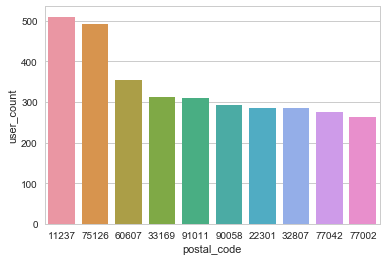

In [363]:
ax = sns.barplot(x='postal_code', y="user_count", data=zip_df_top, order=zip_df_top['postal_code'])

### Observation
Areas with zip code 11237 (BROOKLYN, NY) and 75126 (FORNEY, TX) have the largest amount of users, followed by Chicago, IL, North Miami Beach, FL and LA CANADA FLT, CA.

In [366]:
zip_df_tcv = zip_df.sort_values(by=['ttl_video_engaged'], ascending=False).head(10)
zip_df_tcv

,postal_code,user_count,ttl_video_engaged,avg_max_active_time,avg_min_active_time,avg_avg_active_time,avg_age,avg_income
9175,75126,491,19935,7.193483,0,2.201629,21.708861,31015.926005
1264,11237,510,13736,6.058824,0,2.558824,20.176101,23257.769131
9370,76120,249,10258,7.538153,0,2.333333,29.981818,23706.394984
11457,94601,130,8758,9.046154,0,3.684615,19.530120,19513.899937
10764,90058,293,8716,6.163823,0,2.170648,20.584211,43566.268657
4337,33169,312,8093,7.355769,0,2.471154,30.581152,19519.334390
10747,90034,28,7500,15.000000,0,8.035714,25.846154,44864.268243
2685,22301,285,7216,7.638596,0,2.571930,32.089888,85893.474962
10864,91011,310,7210,8.703226,0,2.883871,21.910995,132464.505119
4213,32807,285,7078,4.954386,0,1.526316,18.640212,17628.846816


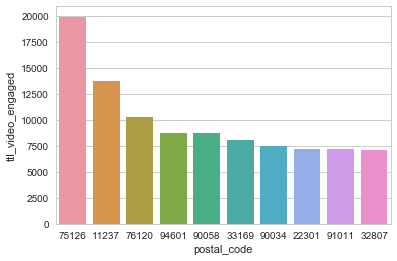

In [367]:
ax = sns.barplot(x='postal_code', y="ttl_video_engaged", data=zip_df_tcv, order=zip_df_tcv['postal_code'])

### Observation
Areas with zip code 75126 (FORNEY, TX) and 11237 (BROOKLYN, NY) have the largest amount of uploaded videos.

In [368]:
zip_df_amv = zip_df.sort_values(by=['avg_max_active_time'], ascending=False).head(10)
zip_df_amv

,postal_code,user_count,ttl_video_engaged,avg_max_active_time,avg_min_active_time,avg_avg_active_time,avg_age,avg_income
11269,93426,1,22,118.0,0,25.0,45.0,35281.000000
55,01523,1,14,117.0,0,36.0,12.0,48312.100840
2964,25276,1,33,116.0,0,3.0,18.0,20277.402135
4505,33777,1,89,113.0,0,16.0,NaN,39625.495376
7888,60659,1,16,110.0,0,35.0,17.0,22984.477034
4780,35585,1,80,106.0,0,92.0,18.0,20280.000000
8304,64834,1,292,104.0,0,29.0,29.0,26989.496718
11353,94024,2,273,102.5,0,32.0,NaN,202120.367208
8088,62664,1,7,102.0,0,12.0,29.0,27588.671875
2086,17824,1,14,102.0,0,23.0,NaN,36258.593750


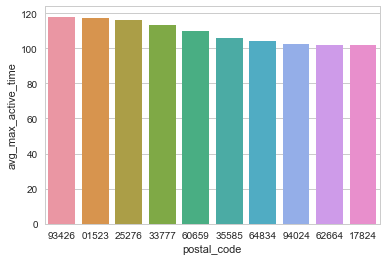

In [369]:
ax = sns.barplot(x='postal_code', y="avg_max_active_time", data=zip_df_amv, order=zip_df_amv['postal_code'])

### Observation
Areas with zip code 89409 (GABBS, NV) and 93426 (BRADLEY, CA) have the largest amount of max view duration.

In [370]:
zip_df_aav = zip_df.sort_values(by=['avg_avg_active_time'], ascending=False).head(10)
zip_df_aav

,postal_code,user_count,ttl_video_engaged,avg_max_active_time,avg_min_active_time,avg_avg_active_time,avg_age,avg_income
4780,35585,1,80,106.0,0,92.0,18.0,20280.000000
9423,76520,1,307,97.0,0,79.0,23.0,20199.280576
3041,26415,1,91,98.0,0,72.0,21.0,24756.538462
11371,94089,1,513,86.0,0,70.0,22.0,54435.469667
4326,33154,1,209,74.0,0,69.0,NaN,144285.250464
12140,99403,1,24,92.0,0,69.0,17.0,29928.373494
244,02670,1,41,97.0,0,69.0,28.0,55699.200000
9209,75220,1,15,87.0,0,66.0,NaN,60038.058252
5871,44672,1,71,86.0,0,64.0,18.0,21027.176781
8377,66025,1,11,94.0,0,60.0,NaN,28779.619565


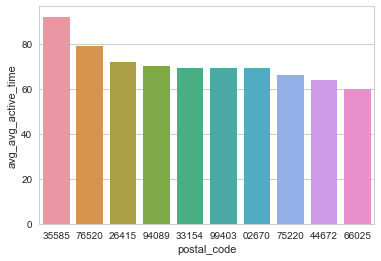

In [371]:
ax = sns.barplot(x='postal_code', y="avg_avg_active_time", data=zip_df_aav, order=zip_df_aav['postal_code'])

### Observation
Areas with zip code 35585 (SPRUCE PINE, AL) and 76520 (CAMERON, TX) have the largest amount of average view duration.

**Plot histogram to show the distribution of income data**

In [372]:
income_df = zip_df.dropna(subset=['avg_income'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a3538dc88>]],
      dtype=object)

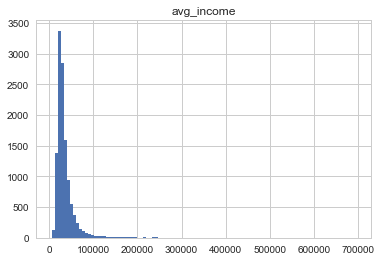

In [373]:
income_df.hist(column='avg_income', bins=100)

**As income from each zip code is scattered, we need to group them into income ranges in order to analyze**

According to distribution plot above, we divide income into 13 ranges. The first ten groups are from 0 to 100,000, 10,000 interval per group. The rest three groups are 100,000 to 150,000, 150,000 to 200,000 and above 200,000.

In [374]:
seg= np.arange(0, 100000, 10000)
seg = np.append(seg, [100000, 150000, 200000, 800000])
seg

array([     0,  10000,  20000,  30000,  40000,  50000,  60000,  70000,
        80000,  90000, 100000, 150000, 200000, 800000])

**Create an income range dataframe**

In [378]:
grouped_income = income_df.groupby(pd.cut(income_df["avg_income"], seg))
income_df

,postal_code,user_count,ttl_video_engaged,avg_max_active_time,avg_min_active_time,avg_avg_active_time,avg_age,avg_income
0,01001,6,355,6.166667,0,1.666667,22.333333,33398.284960
1,01002,2,26,21.000000,0,3.500000,29.000000,49270.961776
2,01007,1,28,1.000000,0,0.000000,18.000000,39091.853933
3,01013,3,17,0.000000,0,0.000000,26.000000,23047.140567
4,01020,2,174,1.000000,0,0.000000,17.000000,27995.212145
5,01027,2,42,2.000000,0,0.000000,18.000000,35097.239264
6,01030,3,30,1.666667,0,0.000000,12.000000,35558.570119
7,01033,1,24,7.000000,0,2.000000,18.000000,37233.275563
8,01040,12,99,0.250000,0,0.000000,16.800000,24226.839237
9,01056,5,781,15.600000,0,6.200000,26.750000,34518.997797


In [379]:
g_income_df = grouped_income.size().to_frame('zipcode_count')
g_income_df = g_income_df.join(grouped_income.agg({'user_count': 'mean'}).rename(columns={'user_count': 'avg_user_count'}))
g_income_df = g_income_df.join(grouped_income.agg({'ttl_video_engaged': 'mean'}))
g_income_df = g_income_df.join(grouped_income.agg({'avg_max_active_time': 'mean'}))
g_income_df = g_income_df.join(grouped_income.agg({'avg_min_active_time': 'mean'}))
g_income_df = g_income_df.join(grouped_income.agg({'avg_avg_active_time': 'mean'}))
g_income_df = g_income_df.join(grouped_income.agg({'avg_age': 'mean'}))
g_income_df.index.name = 'income_range'
g_income_df.reset_index(inplace=True)
g_income_df

,income_range,zipcode_count,avg_user_count,ttl_video_engaged,avg_max_active_time,avg_min_active_time,avg_avg_active_time,avg_age
0,"(0, 10000]",15,6.666667,129.400000,5.613543,0,2.020797,17.694218
1,"(10000, 20000]",1648,9.161408,240.336165,5.689565,0,1.940001,21.393550
2,"(20000, 30000]",4914,5.915140,171.593814,5.827898,0,2.002719,21.829331
3,"(30000, 40000]",2718,6.520235,191.966519,5.502411,0,1.851345,22.584875
4,"(40000, 50000]",1232,6.456981,208.384740,6.271618,0,2.129503,20.512260
5,"(50000, 60000]",620,5.483871,173.011290,5.887523,0,2.193056,22.769977
6,"(60000, 70000]",328,6.996951,212.780488,5.758975,0,1.943945,27.232437
7,"(70000, 80000]",185,5.918919,167.902703,5.469537,0,1.814291,20.668609
8,"(80000, 90000]",117,10.085470,283.307692,6.157655,0,2.092662,24.481858
9,"(90000, 100000]",75,9.933333,222.586667,5.332921,0,1.646464,24.276273


**Plot relationship between income and metrics**

In [380]:
labels = ['{0}-{1}k'.format(i * 10, (i + 1) * 10) for i in range(10)]
labels.extend(['100-150k', '150-200k', '200-800k'])

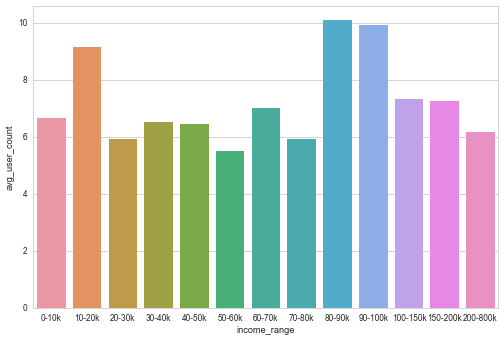

In [381]:
my_dpi = 60

fig = plt.figure(1, figsize=(600/my_dpi, 400/my_dpi), dpi=my_dpi)
ax = fig.add_subplot(111)

sns.barplot(x='income_range', y="avg_user_count", data=g_income_df, ax=ax)
ax.set_xticklabels(labels)
plt.show()

### Observation
Income from 80,000 to 100,000 has the largest amount of users. Income from 10,000 to 20,000 also has high amount of users.

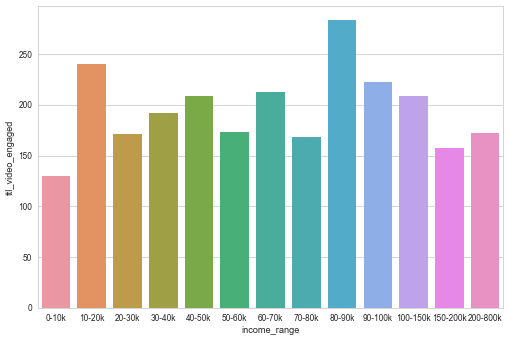

In [384]:
my_dpi = 60

fig = plt.figure(1, figsize=(600/my_dpi, 400/my_dpi), dpi=my_dpi)
ax = fig.add_subplot(111)

sns.barplot(x='income_range', y="ttl_video_engaged", data=g_income_df, ax=ax)
ax.set_xticklabels(labels)
plt.show()

### Observation
Income from 80,000 to 90,000 uploaded the largest amount of videos. Income from 10,000 to 20,000 also has high amount of uploaded videos.

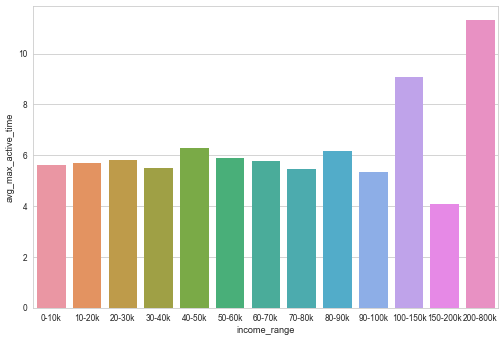

In [386]:
my_dpi = 60

fig = plt.figure(1, figsize=(600/my_dpi, 400/my_dpi), dpi=my_dpi)
ax = fig.add_subplot(111)

sns.barplot(x='income_range', y="avg_max_active_time", data=g_income_df, ax=ax)
ax.set_xticklabels(labels)
plt.show()

### Observation
Income above 200,000 has the highest max view duration value.

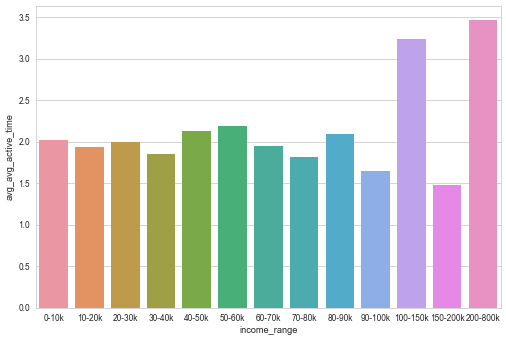

In [388]:
my_dpi = 60

fig = plt.figure(1, figsize=(600/my_dpi, 400/my_dpi), dpi=my_dpi)
ax = fig.add_subplot(111)

sns.barplot(x='income_range', y="avg_avg_active_time", data=g_income_df, ax=ax)
ax.set_xticklabels(labels)
plt.show()

### Observation
Income above 200,000 and from 100,000 to 150,000 has the highest max view duration value.

### extract percentage from view_hour
- sum columns and rows to get an overview
- 
- get pct(eg: morning_percent = sum(morning) / sum(morning, afternoon, ...)

#### overview

In [389]:
#sum columns and rows
col_sum = df[['early_morning', 'morning', 'afternoon', 'evening', 'night', 'late_night']]

df['sum_viewtimes'] = col_sum.sum(axis = 1)
col_sum.sum(axis = 0)
# most freq view hour: afternoon, visualize later


early_morning     344794
morning          1096548
afternoon        1894158
evening           968489
night             934499
late_night        464136
dtype: int64

In [390]:
#Calculate row-wise proportions of each view_hour


In [391]:
df['freq_hour_value'] = df[['early_morning','morning','afternoon','evening','night','late_night']].max(axis=1)
df_hour = df[['early_morning','morning','afternoon','evening','night','late_night']]


In [392]:
df['freq_hour'] = df_hour.idxmax(axis=1)
df.groupby('freq_hour').mean()
#any insight?

,user_id,count_video,max_viewduration,min_viewduration,avg_viewduration,early_morning,morning,afternoon,evening,night,late_night,biweek1,biweek2,biweek3,biweek4,biweek5_nafter,age,lat,long,sum_viewtimes,freq_hour_value
freq_hour,,,,,,,,,,,,,,,,,,,,,
afternoon,196199.125720,23.502869,4.733950,0.0,1.623041,0.727821,2.586152,19.039569,2.556390,2.154357,0.930126,8.610479,2.442321,1.337933,0.776261,1.135338,21.954910,40.607877,-40.439171,27.994414,19.039569
early_morning,200564.005687,23.697481,4.712828,0.0,1.544732,18.744516,2.138756,2.612079,1.624357,1.544552,1.097680,8.808612,1.772050,0.981222,0.703801,0.582920,22.087752,39.898631,-46.182734,27.761939,18.744516
evening,186950.330911,18.740583,4.288119,0.0,1.463338,0.428284,1.222951,2.347562,15.274526,1.580186,0.441615,5.607842,1.392053,0.710469,0.404941,0.632336,21.488860,40.819449,-41.477595,21.295125,15.274526
late_night,239512.022103,23.926948,4.733579,0.0,1.573427,0.836289,1.236763,2.520979,1.554321,2.150849,19.015797,8.822927,1.843282,1.049138,0.619381,0.862887,23.202941,37.830575,-58.306125,27.314998,19.015797
morning,204707.822773,22.235227,4.322372,0.0,1.431310,0.746305,18.103623,3.293615,1.711020,1.480185,0.486616,8.173320,1.648579,0.918145,0.471425,0.704516,21.660499,40.975646,-43.009209,25.821365,18.103623
night,193520.320503,22.159634,4.426191,0.0,1.452371,0.559411,1.634601,2.725480,2.012311,17.365811,1.083475,7.278016,1.882764,0.979168,0.549921,1.181231,21.575829,40.207462,-44.020543,25.381089,17.365811


### Define Y as our response value

**y=1 case**
- They must come back within 2 weeks after registration. 
- biweek1 doesn't count the case when users register and engage at same day.
- Users should come back at least once after 2 weeks

Otherwise, y=0

In [393]:
# first method:
# week1_retend = []
# for times in df.biweek1:
#     if times != 0:
#         week1_retend.append(True)
#     else:
#         week1_retend.append(False)
# week1_retend   
# is_biweek1 = pd.Series(week1_retend)

# second method:
is_biweek1 = df.biweek1 > 0
df['is_bi1'] = is_biweek1
#df['is_bi1'] = df.biweek1 > 0
#sum(df['is_bi1'])

#### 1. How many users engage in videos after signing up in the first two weeks


In [394]:
df_biweek1 = df[is_biweek1]
df_biweek1.shape

(47782, 35)

#### 2. How many users engage in videos in both biweek1 and biweek2


In [395]:
is_biweek2 = df.biweek2 > 0
df['is_bi2'] = is_biweek2
df_biweek12 = df[is_biweek1 & is_biweek2]
df_biweek12.shape

(9325, 36)

#### 3. How many users engage in videos in 3 consecutive biweeks

In [396]:
is_biweek3 = df.biweek3 > 0
df['is_bi3'] = is_biweek3
df_biweek123 = df[is_biweek1 & is_biweek2 & is_biweek3]
df_biweek123.shape

(3150, 37)

#### 4. How many users engage in videos in 4 consecutive biweeks

In [397]:
is_biweek4 = df.biweek4 > 0
df['is_bi4'] = is_biweek4
is_biweek5_nafter = df.biweek5_nafter > 0
df['is_bi5_nafter'] = is_biweek5_nafter
df_biweek1234 = df[is_biweek1 & is_biweek2 & is_biweek3 & is_biweek4]
df_biweek1234.shape

(1057, 39)

Since the data size is so small after 3 consecutive biweeks, we'll define users with at least two biweeks come back frequency as our stick users. In stats sense, those users have y = 1, and otherwise y = 0.

#### 5. Define Stickness

In [398]:
is_atleast1 = is_biweek1 & (is_biweek2 | is_biweek3 | is_biweek4 | is_biweek5_nafter)
df['stickness'] = is_atleast1
#is_atleast1 = pd.Series(df)
df.head(5)
sum(is_atleast1)
# method 2 (in one step)
#df['stickness'] = (df.biweek1>0) & ((df.biweek2>0) | (df.biweek3>0) | (df.biweek4>0) | (df.biweek5_nafter>0))

12621

In [399]:
df['stickness'].describe()

#sum(df['stickness'])/len(df)
stick_pct = "{0:.2f}%".format(sum(df['stickness'])/len(df)*100)
print('User stickness is',stick_pct)

User stickness is 5.74%


#### 6. Ratio in each period

In [400]:
# change all True False value to 0 and 1
df[['is_bi1','is_bi2','is_bi3','is_bi4','is_bi5_nafter','stickness']] = df[['is_bi1','is_bi2','is_bi3','is_bi4','is_bi5_nafter','stickness']].astype(int)
df.describe().iloc[1,16:22]

age                21.857882
lat                40.416729
long              -43.236139
sum_viewtimes      25.954405
freq_hour_value    17.932632
is_bi1              0.217471
Name: mean, dtype: float64

#### 7. Define CVR for each funnel


In [401]:
len(df),len(df_biweek1),len(df_biweek12),len(df_biweek123),len(df_biweek1234)

(219717, 47782, 9325, 3150, 1057)

In [402]:
# visualize it!!!!!!!!!!!!!!!!
#index = [0,1,2,3,4]
#columns = ['biweek','funnel', 'cvr']
#pd.DataFrame

In [403]:
df.head(5)

,user_id,register,count_video,max_viewduration,min_viewduration,avg_viewduration,early_morning,morning,afternoon,evening,night,late_night,biweek1,biweek2,biweek3,biweek4,biweek5_nafter,user_type,inserted_date_pst,age,age_group,birthdate,gender,lat,long,country,region,locality,postal_code,info,gender_fb,sum_viewtimes,freq_hour_value,freq_hour,is_bi1,is_bi2,is_bi3,is_bi4,is_bi5_nafter,stickness
0,7746,2018-04-16,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,guest,2018-04-15,NaN,NaN,NaN,NaN,40.2361,28.9707,TR,Bursa,Bursa,16140,NaN,NaN,1,1,late_night,0,0,0,0,0,0
1,7775,2018-04-16,11,0,0,0,0,0,0,0,0,14,0,0,0,0,0,user,2018-04-15,17.0,13-17,2001-03-06,male,57.7167,11.9667,SE,Västra Götaland,Gothenburg,408 02,NaN,NaN,14,14,late_night,0,0,0,0,0,0
2,7628,2018-04-16,20,0,0,0,0,0,0,0,0,21,0,0,0,0,0,guest,2018-04-15,NaN,NaN,NaN,NaN,41.0000,20.0000,AL,NaN,NaN,NaN,NaN,NaN,21,21,late_night,0,0,0,0,0,0
3,7885,2018-04-16,43,0,0,0,0,0,0,0,0,45,0,0,0,0,0,guest,2018-04-15,NaN,NaN,NaN,NaN,-23.6000,-46.5667,BR,Sao Paulo,São Caetano do Sul,NaN,NaN,NaN,45,45,late_night,0,0,0,0,0,0
4,7879,2018-04-16,3,0,0,0,0,0,0,0,0,3,0,0,0,0,0,user,2018-04-15,NaN,NaN,NaN,male,-14.7889,-39.0465,BR,Bahia,Ilhéus,NaN,"{""name"":""Viz Urk"",""email"":""vinizurk@gmail.com...",male,3,3,late_night,0,0,0,0,0,0


## Visualize Users' location

- The first graph with red dots is stickness user distributions.
- The second graph with blue dots is non-stickness user distributions.

In [404]:
import os
!pip install mapboxgl
from mapboxgl.utils import *
from mapboxgl.viz import *
import sys
import fileinput


token = 'pk.eyJ1Ijoid2luZHNub3ciLCJhIjoiY2prM25xd3dtMDhweTN2bWVidGVpeGFwZCJ9.MiHqwxivv3xMmSerNUtWHg'

filtered_data = df[(df['lat'].notnull()) & (df['long'].notnull())]

# stick users
filtered_stick = filtered_data[filtered_data['stickness'] == 1]

file_name = 'stick_user.geojson'

df_to_geojson(filtered_stick, filename=file_name,
              properties=['user_id'],
              lat='lat', lon='long', precision=3)

# There is a bug with mapboxgl library
# it may write an empty entry at the beginning
for i, line in enumerate(fileinput.input(file_name, inplace=1)):
    if i == 1 and line.startswith(','):
        sys.stdout.write(line[1:])
    else:
        sys.stdout.write(line)

color_stops = create_color_stops([1, 10, 100, 1000], colors='Reds')

viz = ClusteredCircleViz(file_name,
                         access_token=token,
                         color_stops = color_stops,
                         radius_stops = [[1,5], [10, 10], [50, 15], [100, 20]],
                         radius_default = 2,
                         cluster_maxzoom = 10,
                         cluster_radius = 30,
                         label_size = 12,
                         opacity = 0.9,
                         center = (-95, 40),
                         zoom = 3
                        )

viz.show()

# non-stickness users
filtered_non_stick = filtered_data[filtered_data['stickness'] == 0]

file_name = 'nonstick_user.geojson'

df_to_geojson(filtered_non_stick, filename=file_name,
              properties=['user_id'],
              lat='lat', lon='long', precision=3)

# There is a bug with mapboxgl library
# it may write an empty entry at the beginning
for i, line in enumerate(fileinput.input(file_name, inplace=1)):
    if i == 1 and line.startswith(','):
        sys.stdout.write(line[1:])
    else:
        sys.stdout.write(line)

color_stops = create_color_stops([1, 10, 100, 1000, 10000], colors='Reds')

viz = ClusteredCircleViz(file_name,
                         access_token=token,
                         color_stops = color_stops,
                         radius_stops = [[1,5], [10, 10], [50, 15], [100, 20]],
                         radius_default = 2,
                         cluster_maxzoom = 10,
                         cluster_radius = 30,
                         label_size = 12,
                         opacity = 0.9,
                         center = (-95, 40),
                         zoom = 3
                        )

viz.show()

distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [405]:
# df['is_early_morning'] = (df.early_morning > 0).astype(int)
#df['is_morning'] = (df.morning > 0).astype(int)
#df['is_afternoon'] = (df.afternoon > 0).astype(int)
#df['is_afternoon'] = (df.afternoon > 0).astype(int)
#df['is_night'] = (df.afternoon > 0).astype(int)
#is_morning = df.morning > 0
#is_afternoon = df.afternoon > 0
#df[['early_morning','morning','afternoon','evening','night','late_night']] = df[['early_morning','morning','afternoon','evening','night','late_night']].astype(int)

#df['sum_times'] = df['']

In [406]:
df

,user_id,register,count_video,max_viewduration,min_viewduration,avg_viewduration,early_morning,morning,afternoon,evening,night,late_night,biweek1,biweek2,biweek3,biweek4,biweek5_nafter,user_type,inserted_date_pst,age,age_group,birthdate,gender,lat,long,country,region,locality,postal_code,info,gender_fb,sum_viewtimes,freq_hour_value,freq_hour,is_bi1,is_bi2,is_bi3,is_bi4,is_bi5_nafter,stickness
0,7746,2018-04-16,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,guest,2018-04-15,NaN,NaN,NaN,NaN,40.2361,28.9707,TR,Bursa,Bursa,16140,NaN,NaN,1,1,late_night,0,0,0,0,0,0
1,7775,2018-04-16,11,0,0,0,0,0,0,0,0,14,0,0,0,0,0,user,2018-04-15,17.0,13-17,2001-03-06,male,57.7167,11.9667,SE,Västra Götaland,Gothenburg,408 02,NaN,NaN,14,14,late_night,0,0,0,0,0,0
2,7628,2018-04-16,20,0,0,0,0,0,0,0,0,21,0,0,0,0,0,guest,2018-04-15,NaN,NaN,NaN,NaN,41.0000,20.0000,AL,NaN,NaN,NaN,NaN,NaN,21,21,late_night,0,0,0,0,0,0
3,7885,2018-04-16,43,0,0,0,0,0,0,0,0,45,0,0,0,0,0,guest,2018-04-15,NaN,NaN,NaN,NaN,-23.6000,-46.5667,BR,Sao Paulo,São Caetano do Sul,NaN,NaN,NaN,45,45,late_night,0,0,0,0,0,0
4,7879,2018-04-16,3,0,0,0,0,0,0,0,0,3,0,0,0,0,0,user,2018-04-15,NaN,NaN,NaN,male,-14.7889,-39.0465,BR,Bahia,Ilhéus,NaN,"{""name"":""Viz Urk"",""email"":""vinizurk@gmail.com...",male,3,3,late_night,0,0,0,0,0,0
5,7900,2018-04-16,7,0,0,0,0,9,0,0,0,0,0,0,0,0,0,user,2018-04-15,24.0,18-24,1994-04-09,male,-6.1744,106.8294,ID,Jakarta,Jakarta,NaN,"{""name"":""Ryan Abimanyu"",""email"":""ryanabimanyu...",male,9,9,morning,0,0,0,0,0,0
6,7902,2018-04-16,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,guest,2018-04-15,NaN,NaN,NaN,NaN,34.2475,-82.1470,US,South Carolina,Greenwood,29649,NaN,NaN,2,2,late_night,0,0,0,0,0,0
7,7924,2018-04-16,4,0,0,0,0,0,0,0,0,4,0,0,0,0,0,guest,2018-04-15,NaN,NaN,NaN,NaN,-9.5333,-77.5333,PE,Ancash,Huaraz,NaN,NaN,NaN,4,4,late_night,0,0,0,0,0,0
8,7932,2018-04-16,14,0,0,0,0,14,0,0,0,0,0,0,0,0,0,guest,2018-04-15,NaN,NaN,NaN,NaN,45.4299,10.9844,IT,Veneto,Verona,37131,NaN,NaN,14,14,morning,0,0,0,0,0,0
9,7939,2018-04-16,2,0,0,0,0,2,0,0,0,0,0,0,0,0,0,user,2018-04-16,NaN,NaN,NaN,female,50.0833,14.4667,CZ,Hlavni mesto Praha,Prague,130 00,"{""name"":""Pepinka Preislerova"",""email"":""pepink...",female,2,2,morning,0,0,0,0,0,0


**What is the distribution of categorical features for users**

- "Sticky" users are more than 5 times active than "non-sticky" users among all different hours in a day
- 5 **age groups**, users among age 13 - 17 are majority
- Users in age 35+ years old group are more likely to stick
- USA has the most large user groups about 40%
- California is the region with the highest users numbers

In [407]:
df.groupby('stickness').mean()

,user_id,count_video,max_viewduration,min_viewduration,avg_viewduration,early_morning,morning,afternoon,evening,night,late_night,biweek1,biweek2,biweek3,biweek4,biweek5_nafter,age,lat,long,sum_viewtimes,freq_hour_value,is_bi1,is_bi2,is_bi3,is_bi4,is_bi5_nafter
stickness,,,,,,,,,,,,,,,,,,,,,,,,,,
0,196728.950327,15.503660,2.525775,0.0,0.956759,0.991936,3.325786,5.852986,2.870741,2.719290,1.365845,3.728054,0.273994,0.201588,0.119684,0.263293,21.795920,40.536593,-42.265223,17.126584,14.073154,0.169781,0.020628,0.013076,0.008199,0.010710
1,238823.271532,133.273829,37.423501,0.0,10.853974,11.042548,32.310514,54.039141,29.630774,29.422787,14.362966,75.047302,29.389747,15.064575,8.556137,11.806513,22.518458,38.548913,-58.365738,170.808731,81.262182,1.000000,0.738848,0.403534,0.205451,0.177007


In [408]:
df.groupby('age_group').count().sort_values(['user_id'], ascending=False)

,user_id,register,count_video,max_viewduration,min_viewduration,avg_viewduration,early_morning,morning,afternoon,evening,night,late_night,biweek1,biweek2,biweek3,biweek4,biweek5_nafter,user_type,inserted_date_pst,age,birthdate,gender,lat,long,country,region,locality,postal_code,info,gender_fb,sum_viewtimes,freq_hour_value,freq_hour,is_bi1,is_bi2,is_bi3,is_bi4,is_bi5_nafter,stickness
age_group,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
13-17,60856,60856,60856,60856,60856,60856,60856,60856,60856,60856,60856,60856,60856,60856,60856,60856,60856,60856,60856,60856,60856,60419,56145,56145,60856,51631,51102,49323,19638,11878,60856,60856,60856,60856,60856,60856,60856,60856,60856
18-24,19184,19184,19184,19184,19184,19184,19184,19184,19184,19184,19184,19184,19184,19184,19184,19184,19184,19184,19184,19184,19184,19058,17080,17080,19184,15872,15724,14818,7067,2428,19184,19184,19184,19184,19184,19184,19184,19184,19184
0-12,13367,13367,13367,13367,13367,13367,13367,13367,13367,13367,13367,13367,13367,13367,13367,13367,13367,13367,13367,13367,13367,13224,12397,12397,13367,11644,11481,11214,2738,1314,13367,13367,13367,13367,13367,13367,13367,13367,13367
25-34,8901,8901,8901,8901,8901,8901,8901,8901,8901,8901,8901,8901,8901,8901,8901,8901,8901,8901,8901,8901,8901,8857,7794,7794,8900,7310,7221,6696,3394,888,8901,8901,8901,8901,8901,8901,8901,8901,8901
35+,5405,5405,5405,5405,5405,5405,5405,5405,5405,5405,5405,5405,5405,5405,5405,5405,5405,5405,5405,5405,5405,5371,4780,4780,5405,4543,4482,4312,1532,371,5405,5405,5405,5405,5405,5405,5405,5405,5405


In [409]:
df.groupby('age_group').mean()

,user_id,count_video,max_viewduration,min_viewduration,avg_viewduration,early_morning,morning,afternoon,evening,night,late_night,biweek1,biweek2,biweek3,biweek4,biweek5_nafter,age,lat,long,sum_viewtimes,freq_hour_value,is_bi1,is_bi2,is_bi3,is_bi4,is_bi5_nafter,stickness
age_group,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-12,218787.776764,37.536396,7.960874,0.0,2.729707,2.615172,9.920177,16.201915,8.011072,7.001571,2.905514,17.388045,4.661031,2.402184,1.476023,2.139223,10.655944,40.049123,-58.381246,46.655420,28.511558,0.384080,0.116780,0.069275,0.032692,0.035236,0.120745
13-17,191577.929621,22.323255,5.090722,0.0,1.652245,1.411118,5.094173,8.940828,4.560635,4.213750,1.977636,8.204417,1.806938,0.887308,0.383002,0.599185,16.222706,41.878106,-43.221021,26.198140,18.436407,0.275256,0.072762,0.038780,0.018897,0.021493,0.068851
18-24,203690.360509,26.644600,6.249948,0.0,2.045350,1.932131,5.592734,10.191305,5.076626,5.227533,3.306453,10.019391,2.414981,1.173530,0.772154,1.374844,20.976751,39.107050,-50.334629,31.326783,21.100813,0.283101,0.090127,0.052335,0.028618,0.027262,0.084393
25-34,215283.188181,35.262892,8.239187,0.0,2.711942,2.908325,6.987192,12.979665,6.772835,7.376138,4.164476,13.890462,4.011347,2.420852,1.566790,2.268959,29.704191,37.451660,-57.254018,41.188630,25.496124,0.334344,0.114706,0.069093,0.043591,0.040333,0.115156
35+,227718.500833,46.945421,10.299167,0.0,3.489547,4.590934,11.215356,17.321924,9.446809,10.554487,5.172618,20.162442,6.552636,4.453099,3.117669,5.479371,103.214801,38.434904,-65.741190,58.302128,31.965587,0.358002,0.139870,0.096207,0.059389,0.055319,0.145976


In [410]:
df.groupby('country').count().sort_values(['user_id'], ascending=False).head(10)

,user_id,register,count_video,max_viewduration,min_viewduration,avg_viewduration,early_morning,morning,afternoon,evening,night,late_night,biweek1,biweek2,biweek3,biweek4,biweek5_nafter,user_type,inserted_date_pst,age,age_group,birthdate,gender,lat,long,region,locality,postal_code,info,gender_fb,sum_viewtimes,freq_hour_value,freq_hour,is_bi1,is_bi2,is_bi3,is_bi4,is_bi5_nafter,stickness
country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
US,108570,108570,108570,108570,108570,108570,108570,108570,108570,108570,108570,108570,108570,108570,108570,108570,108570,108570,108570,59359,59359,59359,65213,87715,87715,84798,83241,83251,17976,5638,108570,108570,108570,108570,108570,108570,108570,108570,108570
PL,22286,22286,22286,22286,22286,22286,22286,22286,22286,22286,22286,22286,22286,22286,22286,22286,22286,22286,22286,13427,13427,13427,17609,21239,21239,16894,16855,16755,11153,9281,22286,22286,22286,22286,22286,22286,22286,22286,22286
CA,14941,14941,14941,14941,14941,14941,14941,14941,14941,14941,14941,14941,14941,14941,14941,14941,14941,14941,14941,6383,6383,6383,7313,11223,11223,11025,10980,10226,4313,1461,14941,14941,14941,14941,14941,14941,14941,14941,14941
DE,9543,9543,9543,9543,9543,9543,9543,9543,9543,9543,9543,9543,9543,9543,9543,9543,9543,9543,9543,3758,3758,3758,5038,8725,8725,7618,7601,7597,3398,1803,9543,9543,9543,9543,9543,9543,9543,9543,9543
GB,6911,6911,6911,6911,6911,6911,6911,6911,6911,6911,6911,6911,6911,6911,6911,6911,6911,6911,6911,3596,3596,3596,4072,4814,4814,4663,4656,4659,1799,546,6911,6911,6911,6911,6911,6911,6911,6911,6911
UA,5497,5497,5497,5497,5497,5497,5497,5497,5497,5497,5497,5497,5497,5497,5497,5497,5497,5497,5497,1942,1942,1942,2872,5424,5424,4877,4867,4688,1471,1091,5497,5497,5497,5497,5497,5497,5497,5497,5497
RO,4595,4595,4595,4595,4595,4595,4595,4595,4595,4595,4595,4595,4595,4595,4595,4595,4595,4595,4595,1803,1803,1803,3029,4497,4497,3885,3869,3871,2521,2017,4595,4595,4595,4595,4595,4595,4595,4595,4595
BR,3719,3719,3719,3719,3719,3719,3719,3719,3719,3719,3719,3719,3719,3719,3719,3719,3719,3719,3719,666,666,666,1253,959,959,937,934,243,1024,884,3719,3719,3719,3719,3719,3719,3719,3719,3719
CZ,3251,3251,3251,3251,3251,3251,3251,3251,3251,3251,3251,3251,3251,3251,3251,3251,3251,3251,3251,1494,1494,1494,2243,3215,3215,2980,2977,2979,1907,1262,3251,3251,3251,3251,3251,3251,3251,3251,3251


In [411]:
print("Percentage of U.S. user {0:.1%}".format(df[df['country'] == 'US'].shape[0] / df.shape[0]))

Percentage of U.S. user 49.4%


In [412]:
df.groupby('region').count().sort_values(['user_id'], ascending=False).head(10)

,user_id,register,count_video,max_viewduration,min_viewduration,avg_viewduration,early_morning,morning,afternoon,evening,night,late_night,biweek1,biweek2,biweek3,biweek4,biweek5_nafter,user_type,inserted_date_pst,age,age_group,birthdate,gender,lat,long,country,locality,postal_code,info,gender_fb,sum_viewtimes,freq_hour_value,freq_hour,is_bi1,is_bi2,is_bi3,is_bi4,is_bi5_nafter,stickness
region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
California,10755,10755,10755,10755,10755,10755,10755,10755,10755,10755,10755,10755,10755,10755,10755,10755,10755,10755,10755,6160,6160,6160,6746,10709,10709,10755,10671,10672,1440,422,10755,10755,10755,10755,10755,10755,10755,10755,10755
Texas,8624,8624,8624,8624,8624,8624,8624,8624,8624,8624,8624,8624,8624,8624,8624,8624,8624,8624,8624,5298,5298,5298,5726,8601,8601,8624,8495,8495,1041,343,8624,8624,8624,8624,8624,8624,8624,8624,8624
Florida,6145,6145,6145,6145,6145,6145,6145,6145,6145,6145,6145,6145,6145,6145,6145,6145,6145,6145,6145,3750,3750,3750,4081,6137,6137,6145,6107,6107,788,265,6145,6145,6145,6145,6145,6145,6145,6145,6145
New York,5387,5387,5387,5387,5387,5387,5387,5387,5387,5387,5387,5387,5387,5387,5387,5387,5387,5387,5387,3161,3161,3161,3442,5366,5366,5387,5377,5387,854,244,5387,5387,5387,5387,5387,5387,5387,5387,5387
England,4015,4015,4015,4015,4015,4015,4015,4015,4015,4015,4015,4015,4015,4015,4015,4015,4015,4015,4015,2565,2565,2565,2786,4003,4003,4015,4010,4011,888,184,4015,4015,4015,4015,4015,4015,4015,4015,4015
Illinois,3928,3928,3928,3928,3928,3928,3928,3928,3928,3928,3928,3928,3928,3928,3928,3928,3928,3928,3928,2543,2543,2543,2738,3916,3916,3928,3708,3708,537,173,3928,3928,3928,3928,3928,3928,3928,3928,3928
Georgia,3689,3689,3689,3689,3689,3689,3689,3689,3689,3689,3689,3689,3689,3689,3689,3689,3689,3689,3689,2214,2214,2214,2397,3680,3680,3689,3274,3274,491,159,3689,3689,3689,3689,3689,3689,3689,3689,3689
Quebec,3682,3682,3682,3682,3682,3682,3682,3682,3682,3682,3682,3682,3682,3682,3682,3682,3682,3682,3682,1722,1722,1722,2060,3682,3682,3682,3676,3383,1503,622,3682,3682,3682,3682,3682,3682,3682,3682,3682
Ontario,3609,3609,3609,3609,3609,3609,3609,3609,3609,3609,3609,3609,3609,3609,3609,3609,3609,3609,3609,1776,1776,1776,2018,3602,3602,3609,3605,3445,857,356,3609,3609,3609,3609,3609,3609,3609,3609,3609


### Stickness comparison

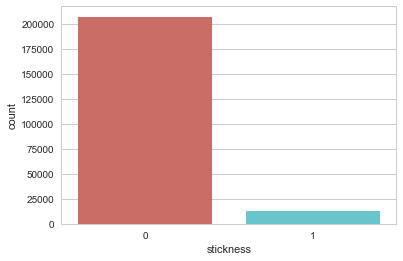

<Figure size 432x288 with 0 Axes>

In [413]:
sns.countplot(x='stickness', data= df, palette = 'hls',)
plt.show()
plt.savefig('count_stickness_plot')

In [414]:
print("Stickness user vs non-stickness user: {0}".format(df[df['stickness'] == 1].shape[0] / df[df['stickness'] == 0].shape[0]))

Stickness user vs non-stickness user: 0.06094275118785491


**observation 1.1**

Non-stickness user numbers are majority, i.e., more than seven times as stickness user numbers.

### Gender 

In [415]:
female_cnt = df[df['gender'] == 'female'].shape[0]
male_cnt = df[df['gender'] == 'male'].shape[0]
print("Female is {0:.1%} more than male".format((female_cnt - male_cnt) / male_cnt))

Female is 179.9% more than male


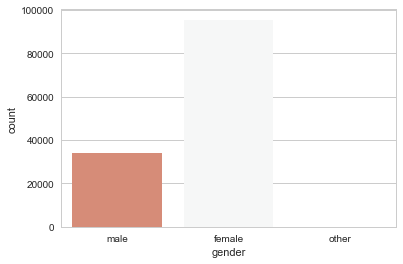

<Figure size 432x288 with 0 Axes>

In [416]:
sns.countplot(x='gender', data= df, palette = 'RdBu',)
plt.show()
plt.savefig('gender_plot')

**observation 2.1**

The number of female is 163% more than male, which means are now targeting more on women

In [417]:
df[['gender', 'stickness']].groupby('gender').mean().sort_values(by='stickness', ascending=False)

,stickness
gender,
other,0.555556
male,0.092312
female,0.075744


**observation 2.2**

However, male's stickness is higher.

### Age group

In [418]:
df[['age_group', 'stickness']].groupby(['age_group']).mean().sort_values(by='stickness', ascending=False)

,stickness
age_group,
35+,0.145976
0-12,0.120745
25-34,0.115156
18-24,0.084393
13-17,0.068851


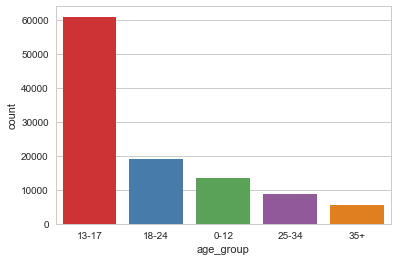

<Figure size 432x288 with 0 Axes>

In [419]:
sns.countplot(x='age_group', data= df, palette = 'Set1',)
plt.show()
plt.savefig('age_plot')

In [420]:
print("Age 13 - 17 has percentage {0:.1%}".format(df[df['age_group'] == '13-17'].shape[0] / df.shape[0]))

Age 13 - 17 has percentage 27.7%


**Observations 3.1** 

The amount of users from age 13 to 17 are more than half, about 59%.

However, stickness ranking is completely reversed comparing to user amount. Age group 13-17 is the lowest stickness group.

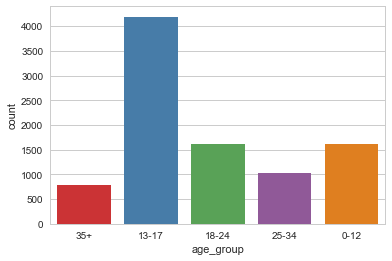

<Figure size 432x288 with 0 Axes>

In [421]:
sns.countplot(x='age_group', data=df[df['stickness'] == 1], palette = 'Set1',)
plt.show()
plt.savefig('age_plot_1')

In [422]:
print("Age 13 - 17 has stickness percentage {0:.1%}".format(df[(df['age_group'] == '13-17') & (df['stickness'] == 1)].shape[0] / df[df['stickness'] == 1].shape[0]))

Age 13 - 17 has stickness percentage 33.2%


**Observations 3.2** 

By combining the user amount and stickness rate, the difference of stickness values between age groups are reduced comparing to user amount. 

### Country or Region

In [423]:
df[['country', 'stickness']].groupby(['country']).mean().sort_values(by='stickness', ascending=False).head(25)

,stickness
country,
IO,0.500000
SX,0.500000
GN,0.333333
LC,0.333333
SC,0.333333
ML,0.250000
DM,0.250000
AM,0.190476
AI,0.166667


**Observations 4.1**   
stickness for YE:Yemen, MZ:Mozambique has full rate, however, this may imply the total user amount is also very low and it is just a bias.

In [424]:
gb = df[['country','stickness']].groupby(['country'])
country_df = gb.size().to_frame(name='counts')
country_df = country_df.join(gb.agg({'stickness': 'sum'}).rename(columns={'stickness': 'stickness_num'}))
country_df['stickness_rate'] = country_df['stickness_num'] / country_df['counts']
country_df = country_df.sort_values(by='stickness_num', ascending=False).head(25)
country_df.index.name = 'country'
country_df.reset_index(inplace=True)
country_df

,country,counts,stickness_num,stickness_rate
0,US,108570,8133,0.074910
1,PL,22286,968,0.043435
2,CA,14941,764,0.051134
3,GB,6911,412,0.059615
4,DE,9543,271,0.028398
5,IN,2634,180,0.068337
6,AU,1033,135,0.130687
7,BR,3719,110,0.029578
8,SE,1670,102,0.061078
9,MX,2548,84,0.032967


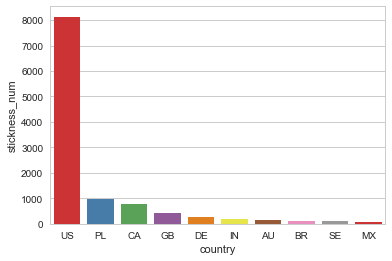

<Figure size 432x288 with 0 Axes>

In [425]:
sns.barplot(x='country', y='stickness_num', data=country_df.head(10), palette = 'Set1',)
plt.show()
plt.savefig('country_plot_1')

**Observations 4.2**   
Most users are located in U.S. and when listing top 25 countries according to stickness, values for tailed countries 
are too small to eliminate deviation. Hence, we will look at data of U.S. instead.

**Assumptions 4.1**

User behaviors could vary in different countries, but this analysis will focus on U.S. user data.

In [426]:
us_df = df[df['country'] == 'US']
gb = us_df[['region','stickness']].groupby(['region'])
region_df = gb.size().to_frame(name='counts')
region_df = region_df.join(gb.agg({'stickness': 'sum'}).rename(columns={'stickness': 'stickness_num'}))
region_df['stickness_rate'] = region_df['stickness_num'] / region_df['counts']
region_df = region_df.sort_values(by='stickness_num', ascending=False).head(25)
region_df.index.name = 'region'
region_df.reset_index(inplace=True)
region_df

,region,counts,stickness_num,stickness_rate
0,California,10755,880,0.081822
1,Texas,8624,709,0.082212
2,Florida,6144,495,0.080566
3,New York,5387,425,0.078894
4,Illinois,3928,335,0.085285
5,Georgia,3689,306,0.082949
6,Pennsylvania,3499,304,0.086882
7,North Carolina,2890,231,0.079931
8,Ohio,2777,212,0.076341
9,New Jersey,2476,208,0.084006


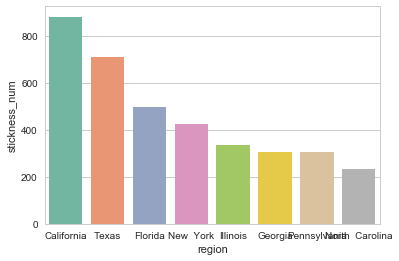

In [427]:
sns.barplot(x='region', y='stickness_num', data = region_df.head(8), palette="Set2")

***Suggestions 4.1***   
We observe that California, Texas, Florida and New York are ranked top 4. This result is related to population and location of
each states in U.S.
My suggestion is to enhance the market in central of U.S.

### Active hours during a day

In [428]:
day_df = df[['stickness', 'early_morning', 'morning', 'afternoon', 'evening', 'night', 'late_night']]
day_df = day_df[day_df['stickness'] == 1].groupby('stickness').mean()
day_df

,early_morning,morning,afternoon,evening,night,late_night
stickness,,,,,,
1,11.042548,32.310514,54.039141,29.630774,29.422787,14.362966


In [429]:
#average
day_df_tran = day_df.transpose()
day_df_tran.columns = ['stickness']
day_df_tran.index.name = 'hours'
day_df_tran.reset_index(inplace=True)
day_df_tran

,hours,stickness
0,early_morning,11.042548
1,morning,32.310514
2,afternoon,54.039141
3,evening,29.630774
4,night,29.422787
5,late_night,14.362966


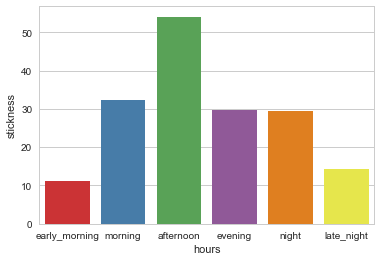

In [430]:
sns.barplot(x='hours', y='stickness', data = day_df_tran, palette="Set1")

**Observations 5.1**   
Users are active during daytime and late night are more likely to be stickness.

In [431]:
col_name = ['early_morning', 'morning', 'afternoon', 'evening', 'night', 'late_night']
sum_li = []
for c in col_name:
    sum_li.append(df[c].sum())
sum_li

[344794, 1096548, 1894158, 968489, 934499, 464136]

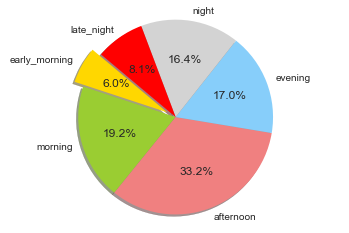

In [432]:
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightgrey', 'red']
explode = (0.1, 0, 0, 0, 0, 0)  # explode 1st slice

plt.pie(sum_li, explode=explode, labels=col_name, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()

**Observations 5.2**   
Total active time of users in a day is correlated with stickness metric.

In [434]:

# col_name = ['early_morning', 'morning', 'afternoon', 'evening', 'night', 'late_night']
# result1 = []
# result2 = []
# for index, row in df.iterrows():
#     max_val = 0
#     for col in col_name:
#         if (row[col] > max_val):
#             max_val = row[col]
#             colname = col
#     result.append(max_val)
#     result2.append(colname)
# se = pd.Series(result1)   
# se1 = pd.Series(result2)   
# df['most_used_time'] = se.values
# df['most_used_period'] = se1.values
# df['most_used_period']
df

,user_id,register,count_video,max_viewduration,min_viewduration,avg_viewduration,early_morning,morning,afternoon,evening,night,late_night,biweek1,biweek2,biweek3,biweek4,biweek5_nafter,user_type,inserted_date_pst,age,age_group,birthdate,gender,lat,long,country,region,locality,postal_code,info,gender_fb,sum_viewtimes,freq_hour_value,freq_hour,is_bi1,is_bi2,is_bi3,is_bi4,is_bi5_nafter,stickness
0,7746,2018-04-16,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,guest,2018-04-15,NaN,NaN,NaN,NaN,40.2361,28.9707,TR,Bursa,Bursa,16140,NaN,NaN,1,1,late_night,0,0,0,0,0,0
1,7775,2018-04-16,11,0,0,0,0,0,0,0,0,14,0,0,0,0,0,user,2018-04-15,17.0,13-17,2001-03-06,male,57.7167,11.9667,SE,Västra Götaland,Gothenburg,408 02,NaN,NaN,14,14,late_night,0,0,0,0,0,0
2,7628,2018-04-16,20,0,0,0,0,0,0,0,0,21,0,0,0,0,0,guest,2018-04-15,NaN,NaN,NaN,NaN,41.0000,20.0000,AL,NaN,NaN,NaN,NaN,NaN,21,21,late_night,0,0,0,0,0,0
3,7885,2018-04-16,43,0,0,0,0,0,0,0,0,45,0,0,0,0,0,guest,2018-04-15,NaN,NaN,NaN,NaN,-23.6000,-46.5667,BR,Sao Paulo,São Caetano do Sul,NaN,NaN,NaN,45,45,late_night,0,0,0,0,0,0
4,7879,2018-04-16,3,0,0,0,0,0,0,0,0,3,0,0,0,0,0,user,2018-04-15,NaN,NaN,NaN,male,-14.7889,-39.0465,BR,Bahia,Ilhéus,NaN,"{""name"":""Viz Urk"",""email"":""vinizurk@gmail.com...",male,3,3,late_night,0,0,0,0,0,0
5,7900,2018-04-16,7,0,0,0,0,9,0,0,0,0,0,0,0,0,0,user,2018-04-15,24.0,18-24,1994-04-09,male,-6.1744,106.8294,ID,Jakarta,Jakarta,NaN,"{""name"":""Ryan Abimanyu"",""email"":""ryanabimanyu...",male,9,9,morning,0,0,0,0,0,0
6,7902,2018-04-16,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,guest,2018-04-15,NaN,NaN,NaN,NaN,34.2475,-82.1470,US,South Carolina,Greenwood,29649,NaN,NaN,2,2,late_night,0,0,0,0,0,0
7,7924,2018-04-16,4,0,0,0,0,0,0,0,0,4,0,0,0,0,0,guest,2018-04-15,NaN,NaN,NaN,NaN,-9.5333,-77.5333,PE,Ancash,Huaraz,NaN,NaN,NaN,4,4,late_night,0,0,0,0,0,0
8,7932,2018-04-16,14,0,0,0,0,14,0,0,0,0,0,0,0,0,0,guest,2018-04-15,NaN,NaN,NaN,NaN,45.4299,10.9844,IT,Veneto,Verona,37131,NaN,NaN,14,14,morning,0,0,0,0,0,0
9,7939,2018-04-16,2,0,0,0,0,2,0,0,0,0,0,0,0,0,0,user,2018-04-16,NaN,NaN,NaN,female,50.0833,14.4667,CZ,Hlavni mesto Praha,Prague,130 00,"{""name"":""Pepinka Preislerova"",""email"":""pepink...",female,2,2,morning,0,0,0,0,0,0


### Bi-weekly active times

In [77]:
week_df = df[['stickness', 'biweek1', 'biweek2', 'biweek3', 'biweek4', 'biweek5_nafter']]
week_df = week_df[week_df['stickness'] == 1].groupby('stickness').mean()
week_df

,biweek1,biweek2,biweek3,biweek4,biweek5_nafter
stickness,,,,,
1,75.047302,29.389747,15.064575,8.556137,11.806513


In [78]:
week_df_tran = week_df.transpose()
week_df_tran.columns = ['stickness']
week_df_tran.index.name = 'weeks'
week_df_tran.reset_index(inplace=True)
week_df_tran

,weeks,stickness
0,biweek1,75.047302
1,biweek2,29.389747
2,biweek3,15.064575
3,biweek4,8.556137
4,biweek5_nafter,11.806513


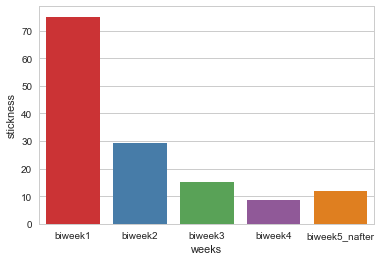

In [79]:
sns.barplot(x='weeks', y='stickness', data = week_df_tran, palette="Set1")

**Observations 6.1**   
Users with stickness are most active on the second bi-week.
The drop between the first and the second bi-week is huge.

In [80]:
col_name = ['biweek1', 'biweek2', 'biweek3', 'biweek4', 'biweek5_nafter']
sum_li = []
for c in col_name:
    sum_li.append(df[c].sum())
sum_li

[1719237, 427671, 231878, 132773, 203537]

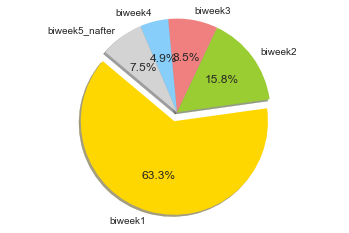

In [81]:
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightgrey']
explode = (0.1, 0, 0, 0, 0)  # explode 1st slice

plt.pie(sum_li, explode=explode, labels=col_name, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()

**Observations 6.1**   
User active record also shows the same trend as stickness curve.

In [82]:
df_drop = df.drop(['user_id','signed_up_at', 'time_zone', 'locale', 'user_type', 'inserted_date_pst', 'signed_up_date_pst', 
                   'age_group', 'birthdate', 'region', 'locality', 'country', 'bio', 'lat', 'long', 'info', 'raw_info',
                   'is_bi1', 'is_bi2', 'is_bi3', 'is_bi4', 'is_bi5_nafter', 'most_used_time'], axis=1)
df_drop['gender'].replace('female', 1, inplace=True)
df_drop['gender'].replace('male', 0, inplace=True)
df_drop.dropna()

KeyError: "labels ['signed_up_at' 'time_zone' 'locale' 'signed_up_date_pst' 'bio' 'raw_info'\n 'most_used_time'] not contained in axis"

In [83]:
pd.options.display.max_columns = None
df_drop

NameError: name 'df_drop' is not defined

In [84]:
np.random.seed(1234)
chosen_idx = np.random.choice(len(df_drop), replace=False, size=round(len(df_drop)*0.8))
mask = np.array([(i in chosen_idx) for i in range(len(df_drop))])

train_df = df_drop[mask]
test_df = df_drop[~mask]

len(train_df),len(test_df)

NameError: name 'df_drop' is not defined

## Split Train and Test Group (X,Y)

In [61]:
X_train = train_df.drop("stickness", axis=1)
Y_train = train_df["stickness"]
X_test  = test_df.drop("stickness", axis=1).copy()
Y_test = test_df["stickness"]
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((52932, 14), (52932,), (13233, 14), (13233,))

## Model, predict and solve

Now we are ready to train a model and predict the required solution. There are 60+ predictive modelling algorithms to choose from. We must understand the type of problem and solution requirement to narrow down to a select few models which we can evaluate. Our problem is a classification and regression problem. We want to identify relationship between output (active or not) with other variables or features (gender, age, followers...). We are also perfoming a category of machine learning which is called supervised learning as we are training our model with a given dataset. With these two criteria - Supervised Learning plus Classification and Regression, we can narrow down our choice of models to a few. These include:

- Logistic Regression
- KNN or k-Nearest Neighbors
- Support Vector Machines
- Naive Bayes classifier
- Decision Tree
- Random Forrest
- Perceptron
- Artificial neural network
- RVM or Relevance Vector Machine

### Logistics Regression

In [62]:
# Logistic Regression
#Try normalized data

from sklearn import preprocessing

standard_scaler = preprocessing.StandardScaler().fit(X_train)
scaled_values = standard_scaler.transform(X_train)
X_train_norm = X_train.copy()
X_train_norm.loc[:,:] = scaled_values

scaled_values = standard_scaler.transform(X_test) 
X_test_norm = X_test.copy()
X_test_norm.loc[:,:] = scaled_values


logreg = LogisticRegression()
logreg.fit(X_train_norm, Y_train)
acc_log = round(logreg.score(X_train_norm, Y_train) * 100, 2)
test_log = round(logreg.score(X_test_norm, Y_test) * 100,2)
print(f'Train model coefficient(confidence score) is {acc_log}%.')
print(f'Test model coefficient(confidence score) is {test_log}%.')

Train model coefficient(confidence score) is 94.43%.
Test model coefficient(confidence score) is 94.32%.


In [63]:
coeff_df = pd.DataFrame(train_df.columns.delete(14))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])
coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
1,biweek2,10.553782
2,biweek3,5.960741
3,biweek4,4.915315
4,biweek5_nafter,4.110898
7,afternoon,2.462901
5,early_morning,1.912077
10,late_night,1.848538
6,morning,1.775651
9,night,1.285625
8,evening,1.092102


**Classification accuracy**: percentage of correct predictions

In [64]:
from sklearn import metrics

# make class predictions for the testing set, first use non-normalized data
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred_class = logreg.predict(X_test)

print(metrics.accuracy_score(Y_test, Y_pred_class))
# Almost no dif between normalized data and non-normalized data

0.9567747298420615


**Null accuracy**: accuracy that could be achieved by always predicting the most frequent class

In [65]:
# examine the class distribution of the testing set (using a Pandas Series method)# exami 
Y_test.value_counts()

0    11732
1     1501
Name: stickness, dtype: int64

In [66]:
# calculate the percentage of ones(avf of active)
Y_test.mean()

0.1134285498375274

In [67]:
# calculate the percentage of zeros# calcul 
1 - Y_test.mean()

0.8865714501624726

In [68]:
# print the first 25 true and predicted responses
print('True:', Y_test.values[0:25])
print('Pred:', Y_pred_class[0:25])

True: [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0]
Pred: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


**Confusion matrix**  
Table that describes the performance of a classification model

In [69]:
# First argument is true values, second argument is predicted values
print(metrics.confusion_matrix(Y_test, Y_pred_class))
# predicted 0; predicted 1
#actual 0: 5       47
#acatual 1: 2     118

[[11694    38]
 [  534   967]]


**Basic terminology**

- True Positives (TP): we correctly predicted that they do become active
- True Negatives (TN): we correctly predicted that they don't become active
- False Positives (FP): we incorrectly predicted that they do become active (a "Type I error")
- False Negatives (FN): we incorrectly predicted that they don't become active (a "Type II error")

In [70]:
# save confusion matrix and slice into four pieces
confusion = metrics.confusion_matrix(Y_test, Y_pred_class)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
print(metrics.confusion_matrix(Y_test, Y_pred_class))

[[11694    38]
 [  534   967]]


### Support Vector Machines

In [71]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
# Support Vector classification
# use normalized data
svc = SVC()
svc.fit(X_train_norm, Y_train)
#Y_pred = svc.predict(X_test_norm)
acc_svc = round(svc.score(X_test_norm, Y_test) * 100, 2)
acc_svc

95.79

### KNN

In [72]:
# check classification accuracy of KNN with K=3
# use normalized data
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train_norm, Y_train)
#Y_pred = knn.predict(X_test_norm)
acc_knn = round(knn.score(X_test_norm, Y_test) * 100, 2)
acc_knn

94.35

### Naive Bayes

In [73]:
# Naive Bayes
# no need to normalize
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
#Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_test, Y_test) * 100, 2)
acc_gaussian

92.19

### Perceptron

In [74]:
# Perceptron
# use normalized data
perceptron = Perceptron()
perceptron.fit(X_train_norm, Y_train)
#Y_pred = perceptron.predict(X_test_norm)
acc_perceptron = round(perceptron.score(X_test_norm, Y_test) * 100, 2)
acc_perceptron

C:\Users\asus\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning:

max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.



90.27

### Linear SVC

In [75]:
# Linear SVC
# use normalized data
linear_svc = LinearSVC()
linear_svc.fit(X_train_norm, Y_train)
#Y_pred = linear_svc.predict(X_test_norm)
acc_linear_svc = round(linear_svc.score(X_test_norm, Y_test) * 100, 2)
acc_linear_svc

93.42

### Stochastic Gradient Descent

In [76]:
# Stochastic Gradient Descent
# use normalized data
sgd = SGDClassifier()
sgd.fit(X_train_norm, Y_train)
#Y_pred = sgd.predict(X_test_norm)
acc_sgd = round(sgd.score(X_test_norm, Y_test) * 100, 2)
acc_sgd

C:\Users\asus\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning:

max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.



95.69

###  Decision Tree

In [77]:
# Decision Tree
# no need to normalize
# visualize decison tree
decision_tree = DecisionTreeClassifier(max_depth = 3)
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_test, Y_test) * 100, 2)
acc_decision_tree

98.77

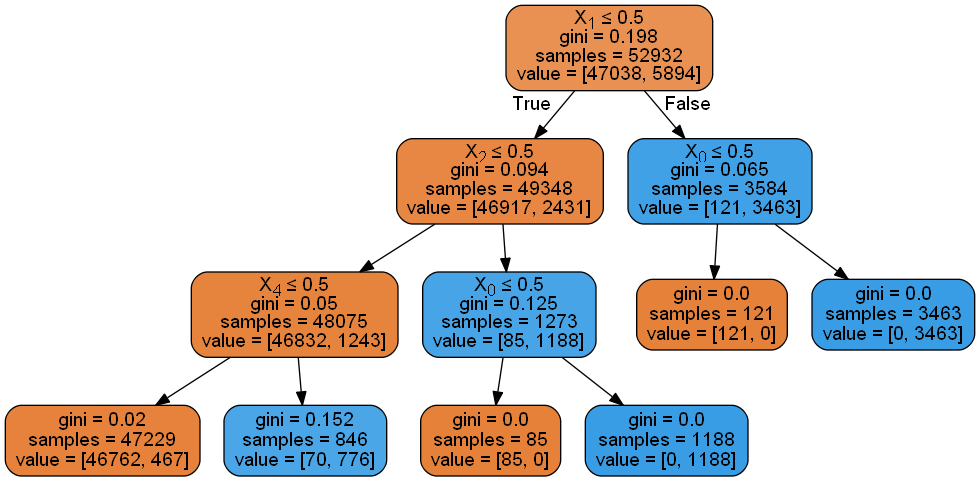

In [78]:
# visualize decision tree
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.tree import DecisionTreeClassifier
dtree=DecisionTreeClassifier(max_depth = 3)
dtree.fit(X_train,Y_train)
dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())


### Random Forest

In [79]:
# Random Forest
# no need to normalize

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_test, Y_test) * 100, 2)
acc_random_forest

99.96

### Model evaluation

We can now rank our evaluation of all the models to choose the best one for our problem. While both Decision Tree and Random Forest score the same, we choose to use Random Forest as they correct for decision trees' habit of overfitting to their training set. 

In [80]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Random Forest,99.96
8,Decision Tree,98.77
0,Support Vector Machines,95.79
6,Stochastic Gradient Decent,95.69
2,Logistic Regression,94.43
1,KNN,94.35
7,Linear SVC,93.42
4,Naive Bayes,92.19
5,Perceptron,90.27


<Figure size 432x288 with 0 Axes>

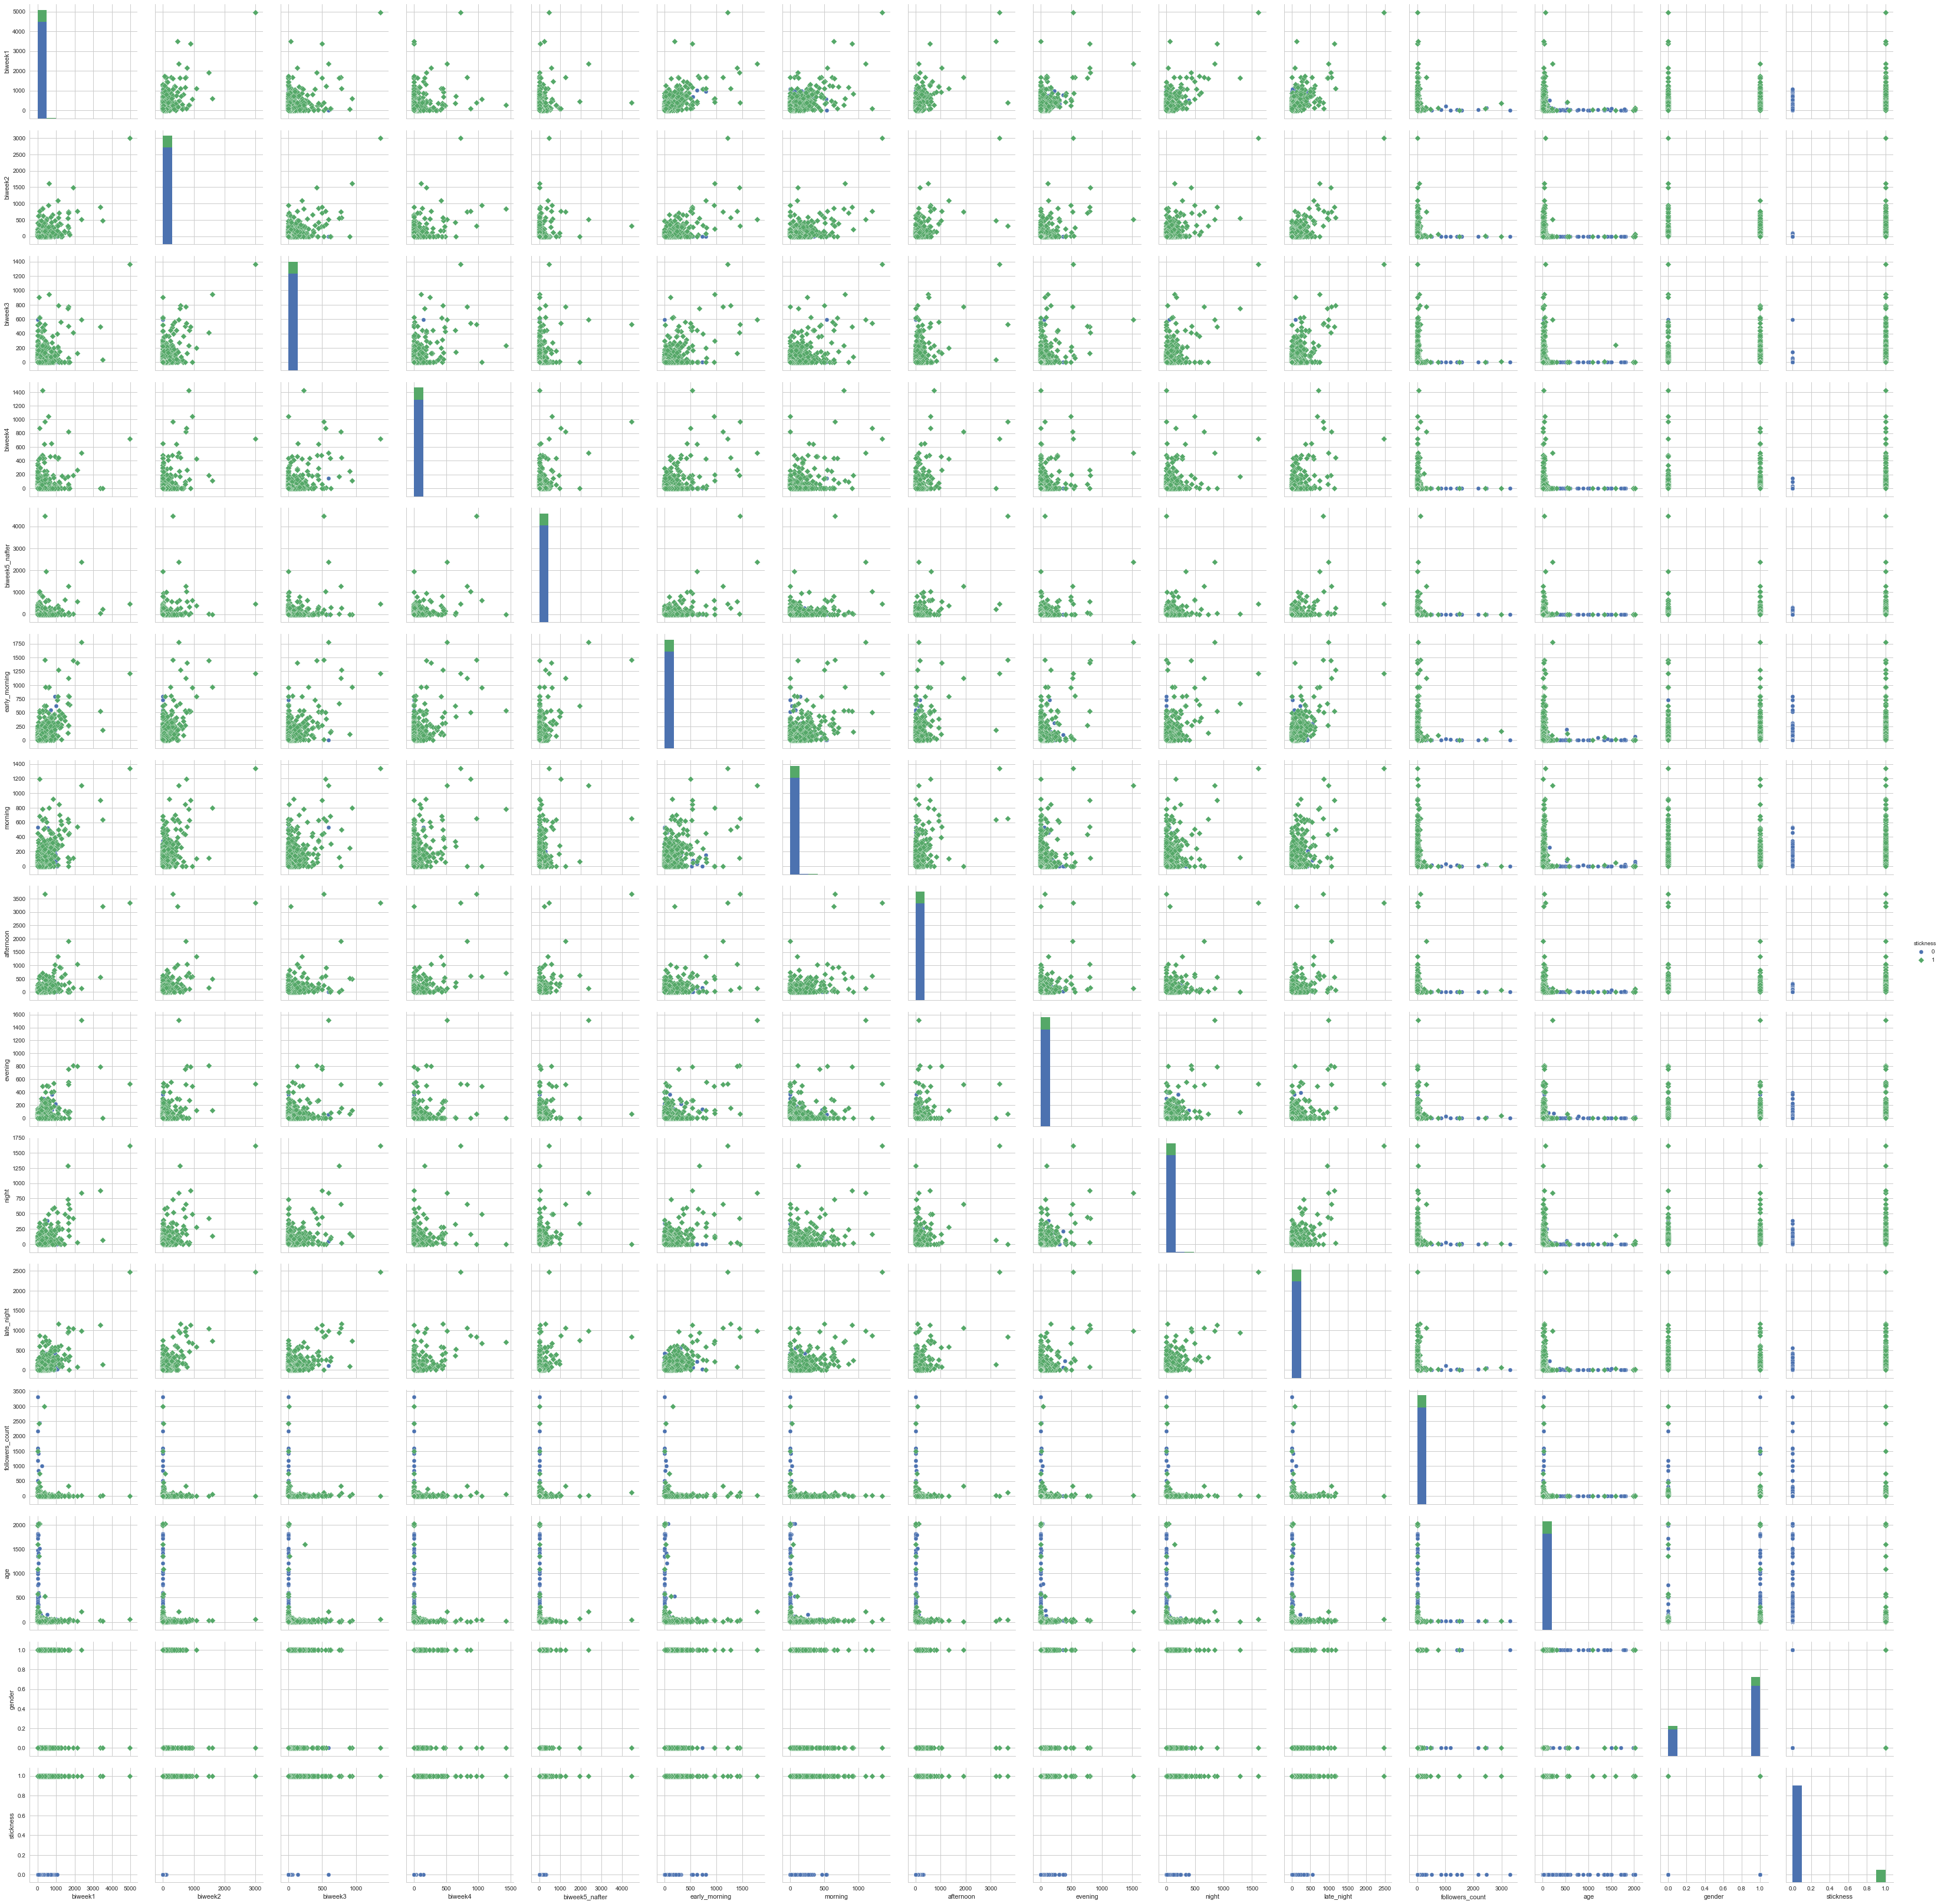

In [81]:
plt.figure()
sns.pairplot(train_df, hue = "stickness", size=3, markers=["o", "D"])
plt.show()

<Figure size 432x288 with 0 Axes>

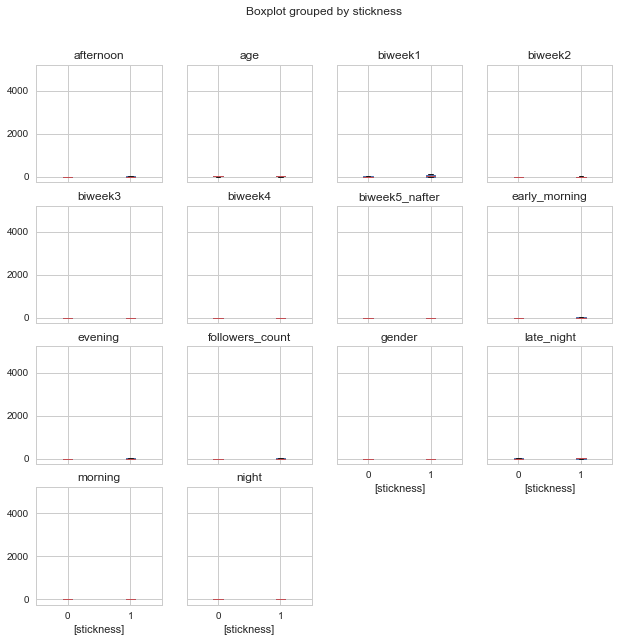

In [82]:
plt.figure()
train_df.boxplot(by="stickness", figsize=(10, 10))

plt.show()

- give some space


SELECT user_id,register_date, COUNT(DISTINCT video_id) count_video,
MAX(elapse_days) max_elapse, MIN(elapse_days) min_elapse,AVG(elapse_days) avg_elapse,
sum(CASE WHEN (view_hour BETWEEN 4 AND 7) THEN 1 ELSE 0 END) AS early_morning,
sum(CASE WHEN (view_hour BETWEEN 8 AND 11) THEN 1 ELSE 0 END) AS morning,
sum(CASE WHEN (view_hour BETWEEN 12 AND 17) THEN 1 ELSE 0 END) AS afternoon,
sum(CASE WHEN (view_hour BETWEEN 18 AND 20) THEN 1 ELSE 0 END) AS evening,
sum(CASE WHEN (view_hour BETWEEN 21 AND 23) THEN 1 ELSE 0 END) AS night,
sum(CASE WHEN (view_hour BETWEEN 0 AND 3) THEN 1 ELSE 0 END) AS late_night,
sum(CASE WHEN (elapse_days >0 and elapse_days <14) THEN 1 ELSE 0 END) AS biweek1,
sum(CASE WHEN (elapse_days >=14 and elapse_days <28) THEN 1 ELSE 0 END) AS biweek2,
sum(CASE WHEN (elapse_days >=28 and elapse_days <42) THEN 1 ELSE 0 END) AS biweek3,
sum(CASE WHEN (elapse_days >=42 and elapse_days <56) THEN 1 ELSE 0 END) AS biweek4,
sum(CASE WHEN (elapse_days >=56) THEN 1 ELSE 0 END) AS biweek5_nafter,
user_type, inserted_date_pst, age, age_group, birthdate, gender, lat, long, country, region, locality, postal_code, info
FROM(
  SELECT user_id, DATE(engaged_at_local) view_date,
      EXTRACT(HOUR FROM engaged_at_local) view_hour, DATE(register_date) register_date, 
      (DATE(engaged_at_local) - DATE(register_date)) elapse_days,video_id
  FROM feed_events
  --define register_date as first engage_local date
  LEFT JOIN (SELECT user_id, MIN(engaged_at_local) register_date FROM feed_events GROUP BY user_id) fe2 
      USING (user_id)
  WHERE user_id > 1000
  AND register_date < engaged_at_local
  --AND (DATE(engaged_at_local) - DATE(engage_date)) >0
  AND user_id NOT IN (SELECT user_id FROM user_data)
  AND user_id IS NOT NULL
  AND event = 'engage_video'
  AND register_date > '2018-04-15'
  AND register_date NOT IN('2018-07-23', '2018-07-25', '2018-07-26', '2018-08-01')
  AND (current_date - register_date) > 30

) fe1
LEFT JOIN fact_users u ON u.id = fe1.user_id
GROUP BY user_id, register_date, user_type, inserted_date_pst, age,age_group, birthdate, gender, lat, long, 
country, region, locality, postal_code, info

- registered_at instead of register